In [86]:
# imports
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')   
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression   
from sklearn.metrics import mean_squared_error, r2_score    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso

# Energy Anomaly & Power Theft Detection - Data Analysis Notebook

## Problem Statement

Kenya's electricity distribution, primarily managed by **Kenya Power and Lighting Company (KPLC)**, faces critical challenges that threaten the sustainability and reliability of the power grid:

### Core Challenges

1. **Revenue Loss from Electricity Theft**
   - Unauthorized power disconnections and meter tampering result in substantial revenue losses
   - Non-technical losses (including illegal connections and meter manipulation) persist as a major issue
   - These activities compromise the financial sustainability of power distribution

2. **Inefficient Detection & Response**
   - Current detection approaches rely on manual inspections, customer reporting, and reactive investigations
   - Manual methods are time-consuming, expensive, and often ineffective
   - Reactive approach fails to identify suspicious patterns in real-time before significant losses occur
   - Grid reliability is compromised due to delayed anomaly detection

3. **Underutilized Smart Grid Data**
   - Despite widespread deployment of smart and prepaid meters, massive volumes of daily consumption data are not fully leveraged
   - Large-scale electricity consumption records lack predictive monitoring and fraud detection systems
   - Data-driven insights remain untapped for proactive grid management

4. **Abnormal Consumption Patterns Not Detected**
   - Suspicious behaviors such as:
     - Sudden drops in consumption levels
     - Frequent disconnection-reconnection cycles
     - Inconsistencies between payment records and actual consumption
     - Meter reading anomalies
   - These indicators of fraudulent activity or meter interference are difficult to identify without advanced analytics

### Project Objective

Develop a **Smart Power Disconnection Analytics System** tailored to Kenya's context that:

- **Leverages machine learning** to automatically detect abnormal disconnections and potential electricity theft
- **Analyzes smart meter data** to identify suspicious consumption patterns and fraud indicators
- **Enables proactive monitoring** of electricity usage for real-time anomaly detection
- **Reduces non-technical losses** through data-driven fraud prevention
- **Supports grid modernization** by enhancing operational efficiency and reliability

### Expected Outcomes

✓ Automated detection of abnormal disconnection patterns  
✓ Identification of high-risk consumption profiles  
✓ Reduced investigation costs through targeted fraud screening  
✓ Improved revenue collection and grid stability  
✓ Foundation for Kenya's smart grid modernization

---

## Methodology & Approach

This analysis implements an end-to-end machine learning pipeline to detect power theft and anomalous consumption patterns:

### Phase 1: Data Integration & Preparation
- **Load & Combine Multiple Data Sources:**
  - Power consumption data (multi-household daily metrics)
  - Weather context (temperature, precipitation, wind speed)
  - KPLC operational schedules (planned outages & maintenance records)
  - Auxiliary building data (class, consumption history)
  - Anomaly detection datasets (meter readings with anomaly flags)

- **Clean & Normalize Data:**
  - Handle missing values with interpolation and forward/backward filling
  - Remove duplicate records and outliers
  - Standardize data types and date formats
  - Engineer temporal features (year, month, day, weekday, weekend flags)

### Phase 2: Exploratory Analysis & Feature Engineering
- **Analyze Consumption Patterns:** Distribution of electricity and gas usage across normal vs. fraudulent cases
- **Create Engineered Features:**
  - Total energy consumption ratios
  - Load type proportions (cooling, heating, equipment efficiency)
  - Seasonal and temporal indicators
  - Building-level aggregations and anomaly rates
- **Identify Key Differentiators:** Metrics that distinguish legitimate usage from potential theft

### Phase 3: Model Development & Evaluation
- **Train Multiple Classifiers:**
  - Logistic Regression (baseline linear model)
  - Random Forest (ensemble with feature importance)
- **Evaluate Performance:**
  - ROC-AUC for discrimination ability
  - Precision & Recall for fraud detection trade-offs
  - F1-Score for balanced performance
  - Confusion matrices for error analysis
- **Feature Importance Analysis:** Determine which consumption metrics best predict fraud

### Phase 4: Insights & Recommendations
- **Visual Discovery:** Comprehensive dashboards showing model performance and key patterns
- **Actionable Insights:** Lead identification for KPLC fraud investigation teams
- **Deployment Ready:** Saved models and scalers for production use

---

In [87]:
# 1. Load: power_multi_household_daily.csv (primary power dataset)
power_path = "power_multi_household_daily.csv"
df_power_daily = pd.read_csv(power_path, low_memory=False)
print(f"✓ Loaded {power_path}: {df_power_daily.shape}")

✓ Loaded power_multi_household_daily.csv: (14420, 9)


In [88]:
# 2. Load: nairobi_weather_2007_2008.csv (weather context)
weather_path = "nairobi_weather_2007_2008.csv"
df_weather = pd.read_csv(weather_path, low_memory=False)
print(f"✓ Loaded {weather_path}: {df_weather.shape}")

✓ Loaded nairobi_weather_2007_2008.csv: (731, 5)


In [89]:
# 3. Load: kplc_daily_schedule.csv (scheduled outages)
kplc_path = "kplc_daily_schedule.csv"
df_kplc = pd.read_csv(kplc_path, low_memory=False)
print(f"✓ Loaded {kplc_path}: {df_kplc.shape}")

✓ Loaded kplc_daily_schedule.csv: (5, 4)


In [90]:
# 4. Load: kplc_planned_outages.csv (maintenance records)
planned_outages_path = "kplc_planned_outages.csv"
df_planned_outages = pd.read_csv(planned_outages_path, low_memory=False)
print(f"✓ Loaded {planned_outages_path}: {df_planned_outages.shape}")

✓ Loaded kplc_planned_outages.csv: (13, 5)


In [91]:
# 5. Load: df.csv (auxiliary data)
df_aux = pd.read_csv("df.csv", low_memory=False)
print(f"✓ Loaded df.csv: {df_aux.shape}")

✓ Loaded df.csv: (560655, 13)


In [92]:
# 6. Load: lead1.0-small.csv (lead dataset)
lead_path = "lead1.0-small.csv"
df_lead = pd.read_csv(lead_path, low_memory=False)
print(f"✓ Loaded {lead_path}: {df_lead.shape}")

print("\n" + "="*80)
print("ALL DATASETS LOADED SUMMARY")
print("="*80)
datasets = {
    'df_power_daily': df_power_daily,
    'df_weather': df_weather,
    'df_kplc': df_kplc,
    'df_planned_outages': df_planned_outages,
    'df_aux': df_aux,
    'df_lead': df_lead
}
for name, df in datasets.items():
    print(f"{name:25} | Shape: {str(df.shape):12} | Columns: {list(df.columns)[:3]}...")
print("="*80)

✓ Loaded lead1.0-small.csv: (1749494, 4)

ALL DATASETS LOADED SUMMARY
df_power_daily            | Shape: (14420, 9)   | Columns: ['meter_id', 'date', 'daily_mean_power']...
df_weather                | Shape: (731, 5)     | Columns: ['date', 'tmax', 'tmin']...
df_kplc                   | Shape: (5, 4)       | Columns: ['date', 'scheduled_outage_today', 'n_scheduled_events']...
df_planned_outages        | Shape: (13, 5)      | Columns: ['area', 'date', 'start_time']...
df_aux                    | Shape: (560655, 13) | Columns: ['0', 'Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)']...
df_lead                   | Shape: (1749494, 4) | Columns: ['building_id', 'timestamp', 'meter_reading']...


In [93]:
# Loading dataset: power_multi_household_daily.csv
power_path = "power_multi_household_daily.csv"

df_power_daily = pd.read_csv(power_path, low_memory=False)
df_power_daily

,meter_id,date,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean
0,MTR_001,2006-12-16,2.617495,0.882098,0.222336,6.660460,236.243763,2.922896,13.082828
1,MTR_001,2006-12-17,2.018833,1.032528,0.097898,6.024453,240.087028,4.051467,9.999028
2,MTR_001,2006-12-18,1.311082,0.862724,0.065486,5.258530,241.231694,3.719576,6.421667
3,MTR_001,2006-12-19,0.992268,1.063872,0.020072,6.750390,241.999313,3.069492,4.926389
4,MTR_001,2006-12-20,1.325185,1.134982,0.026983,5.161571,242.308063,3.345704,6.467361
...,...,...,...,...,...,...,...,...,...
14415,MTR_010,2010-11-22,1.624360,1.346636,0.146076,6.865426,240.197118,3.916832,6.014167
14416,MTR_010,2010-11-23,1.254788,1.004583,0.094465,5.337459,240.575528,3.833612,4.674444
14417,MTR_010,2010-11-24,1.431164,1.020773,0.133426,6.534909,240.030965,3.747974,5.249583
14418,MTR_010,2010-11-25,1.139526,0.955009,0.156308,5.809185,241.536257,2.714365,4.169444


### B.1 Clean & Parse Power Dataset

In [94]:
# parse date and set index if present
if 'date' in df_power_daily.columns:
    df_power_daily['date'] = pd.to_datetime(df_power_daily['date'], errors='coerce')
    df_power_daily.set_index('date', inplace=True)


In [95]:
# basic preview and diagnostics
print(f"Loaded '{power_path}' — shape: {df_power_daily.shape}")
print('\nColumn dtypes:')
print(df_power_daily.dtypes)



Loaded 'power_multi_household_daily.csv' — shape: (14420, 8)

Column dtypes:
meter_id             object
daily_mean_power    float64
daily_std_power     float64
daily_min_power     float64
daily_max_power     float64
voltage_mean        float64
voltage_std         float64
intensity_mean      float64
dtype: object


In [96]:
# checking missing values
print('\nMissing values per column:')
print(df_power_daily.isnull().sum())


Missing values per column:
meter_id             0
daily_mean_power    90
daily_std_power     90
daily_min_power     90
daily_max_power     90
voltage_mean        90
voltage_std         90
intensity_mean      90
dtype: int64


In [97]:
# basic dataset-specific checks
if 'meter_id' in df_power_daily.columns:
    print('\nUnique meters:', df_power_daily['meter_id'].nunique())
for col in ['daily_consumption','consumption','Global_active_power','energy_kwh','total_kwh']:
    if col in df_power_daily.columns:
        print(f"\nSummary for '{col}':")
        display(df_power_daily[col].describe())


Unique meters: 10


In [98]:
# Loading dataset: kplc_daily_schedule.csv 
# file path
kplc_path = "kplc_daily_schedule.csv"

# load dataset
df_kplc = pd.read_csv(kplc_path, low_memory=False)
df_kplc


,date,scheduled_outage_today,n_scheduled_events,total_scheduled_minutes
0,2026-01-18,1,3,1380.0
1,2026-01-20,1,4,1950.0
2,2026-01-21,1,2,960.0
3,2026-01-22,1,3,1380.0
4,2026-01-23,1,1,450.0


### B.2 Clean & Parse KPLC & Weather Datasets

In [99]:
# loading dataset: nairobi_weather_2007_2008.csv
# file path
weather_path = "nairobi_weather_2007_2008.csv"

# load dataset
df_weather = pd.read_csv(weather_path, low_memory=False)
df_weather.head()


,date,tmax,tmin,prcp,wspd_max
0,2007-01-01,24.7,13.1,1.0,17.6
1,2007-01-02,23.2,13.7,0.1,17.4
2,2007-01-03,22.6,14.8,0.9,20.0
3,2007-01-04,21.5,14.9,2.3,21.4
4,2007-01-05,23.3,12.9,0.0,18.5


In [100]:
# parse any `date` column to datetime (safe conversion)
for df, name in [(df_kplc, 'df_kplc'), (df_weather, 'df_weather')]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [101]:
# quick previews and summaries
print(f"Loaded '{kplc_path}' — shape: {df_kplc.shape}")
print('\nColumn dtypes:')
print(df_kplc.dtypes)
print('\nMissing values per column:')
print(df_kplc.isnull().sum())
if 'date' in df_kplc.columns:
    print(f"{kplc_path} date range: {df_kplc['date'].min()} — {df_kplc['date'].max()}")

print('\n' + '-'*60 + '\n')

print(f"Loaded '{weather_path}' — shape: {df_weather.shape}")
print('\nColumn dtypes:')
print(df_weather.dtypes)
print('\nMissing values per column:')
print(df_weather.isnull().sum())
if 'date' in df_weather.columns:
    print(f"{weather_path} date range: {df_weather['date'].min()} — {df_weather['date'].max()}")

Loaded 'kplc_daily_schedule.csv' — shape: (5, 4)

Column dtypes:
date                       datetime64[ns]
scheduled_outage_today              int64
n_scheduled_events                  int64
total_scheduled_minutes           float64
dtype: object

Missing values per column:
date                       0
scheduled_outage_today     0
n_scheduled_events         0
total_scheduled_minutes    0
dtype: int64
kplc_daily_schedule.csv date range: 2026-01-18 00:00:00 — 2026-01-23 00:00:00

------------------------------------------------------------

Loaded 'nairobi_weather_2007_2008.csv' — shape: (731, 5)

Column dtypes:
date        datetime64[ns]
tmax               float64
tmin               float64
prcp               float64
wspd_max           float64
dtype: object

Missing values per column:
date        0
tmax        0
tmin        0
prcp        0
wspd_max    0
dtype: int64
nairobi_weather_2007_2008.csv date range: 2007-01-01 00:00:00 — 2008-12-31 00:00:00


In [102]:
# make copies
df_kplc_clean = df_kplc.copy()
df_weather_clean = df_weather.copy()

In [103]:
# df_kplc cleaning
print('df_kplc: original shape ->', df_kplc_clean.shape)


df_kplc: original shape -> (5, 4)


In [104]:
# drop exact duplicate rows
dup_k = df_kplc_clean.duplicated().sum()
if dup_k:
    df_kplc_clean = df_kplc_clean.drop_duplicates()
    print(f'dropped {dup_k} duplicate rows from df_kplc')

In [105]:
# ensure numeric types
num_cols_k = ['scheduled_outage_today', 'n_scheduled_events', 'total_scheduled_minutes']
for c in num_cols_k:
    if c in df_kplc_clean.columns:
        df_kplc_clean[c] = pd.to_numeric(df_kplc_clean[c], errors='coerce')

In [106]:
# create date features
if 'date' in df_kplc_clean.columns and pd.api.types.is_datetime64_any_dtype(df_kplc_clean['date']):
    df_kplc_clean = df_kplc_clean.sort_values('date')
    df_kplc_clean['year'] = df_kplc_clean['date'].dt.year
    df_kplc_clean['month'] = df_kplc_clean['date'].dt.month
    df_kplc_clean['day'] = df_kplc_clean['date'].dt.day
    df_kplc_clean['weekday'] = df_kplc_clean['date'].dt.weekday
    df_kplc_clean['is_weekend'] = df_kplc_clean['weekday'] >= 5
    df_kplc_clean.set_index('date', inplace=True)


In [107]:
# outlier flag for total minutes (IQR)
if 'total_scheduled_minutes' in df_kplc_clean.columns:
    q1 = df_kplc_clean['total_scheduled_minutes'].quantile(0.25)
    q3 = df_kplc_clean['total_scheduled_minutes'].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    df_kplc_clean['total_minutes_outlier'] = ((df_kplc_clean['total_scheduled_minutes'] < lower) | (df_kplc_clean['total_scheduled_minutes'] > upper))

In [108]:
# simple imputation placeholder (only apply if missing exists)
if df_kplc_clean.isnull().sum().sum() > 0:
    df_kplc_clean['total_scheduled_minutes'].fillna(df_kplc_clean['total_scheduled_minutes'].median(), inplace=True)

print('df_kplc_clean shape ->', df_kplc_clean.shape)
print('-'*60)


df_kplc_clean shape -> (5, 9)
------------------------------------------------------------


In [109]:
# df_weather cleaning 
df_weather_clean.shape


(731, 5)

In [110]:
# drop exact duplicate rows
dup_w = df_weather_clean.duplicated().sum()
if dup_w:
    df_weather_clean = df_weather_clean.drop_duplicates()
    print(f'dropped {dup_w} duplicate rows from df_weather')

In [111]:
# ensure numeric types for weather columns
for c in ['tmax', 'tmin', 'prcp', 'wspd_max']:
    if c in df_weather_clean.columns:
        df_weather_clean[c] = pd.to_numeric(df_weather_clean[c], errors='coerce')

In [112]:
# date features and index
if 'date' in df_weather_clean.columns and pd.api.types.is_datetime64_any_dtype(df_weather_clean['date']):
    df_weather_clean = df_weather_clean.sort_values('date')
    df_weather_clean['temp_range'] = df_weather_clean['tmax'] - df_weather_clean['tmin']
    df_weather_clean['precip_flag'] = df_weather_clean['prcp'] > 0
    df_weather_clean['year'] = df_weather_clean['date'].dt.year
    df_weather_clean['month'] = df_weather_clean['date'].dt.month
    df_weather_clean.set_index('date', inplace=True)

In [113]:
# forward/backward fill or interpolation if missing
if df_weather_clean.isnull().sum().sum() > 0:
    df_weather_clean = df_weather_clean.sort_index().interpolate(method='time').ffill().bfill()

print('df_weather_clean shape ->', df_weather_clean.shape)



df_weather_clean shape -> (731, 8)


In [114]:
# Attempting merge on date 
df_merged = pd.merge(df_kplc_clean.reset_index(), df_weather_clean.reset_index(), on='date', how='left', suffixes=('_kplc','_weather'))
print('Merged shape:', df_merged.shape)

Merged shape: (5, 18)


### D.1 Merge KPLC + Weather (Date-based)

In [115]:
# counting how many rows have matching weather
matched = df_merged['tmax'].notna().sum() if 'tmax' in df_merged.columns else 0
print('Rows with matching weather data:', matched)

Rows with matching weather data: 0


In [116]:
# checking date-range overlap
k_min, k_max = df_kplc_clean.index.min(), df_kplc_clean.index.max()
w_min, w_max = df_weather_clean.index.min(), df_weather_clean.index.max()
print(f"kplc date range: {k_min} — {k_max}")
print(f"weather date range: {w_min} — {w_max}")

kplc date range: 2026-01-18 00:00:00 — 2026-01-23 00:00:00
weather date range: 2007-01-01 00:00:00 — 2008-12-31 00:00:00


In [117]:
# quick preview of cleaned / merged data
print('\nSample (df_kplc_clean):')
print('\nSample (df_weather_clean):')
print('\nSample (df_merged):')
display(df_merged.head())


Sample (df_kplc_clean):

Sample (df_weather_clean):

Sample (df_merged):


,date,scheduled_outage_today,n_scheduled_events,total_scheduled_minutes,year_kplc,month_kplc,day,weekday,is_weekend,total_minutes_outlier,tmax,tmin,prcp,wspd_max,temp_range,precip_flag,year_weather,month_weather
0,2026-01-18,1,3,1380.0,2026,1,18,6,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2026-01-20,1,4,1950.0,2026,1,20,1,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2026-01-21,1,2,960.0,2026,1,21,2,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2026-01-22,1,3,1380.0,2026,1,22,3,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2026-01-23,1,1,450.0,2026,1,23,4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
# Info check for the 3 main datasets
print("=" * 80)
print("Dataset 1: df_power_daily")
print("=" * 80)
df_power_daily.info()

Dataset 1: df_power_daily
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14420 entries, 2006-12-16 to 2010-11-26
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   meter_id          14420 non-null  object 
 1   daily_mean_power  14330 non-null  float64
 2   daily_std_power   14330 non-null  float64
 3   daily_min_power   14330 non-null  float64
 4   daily_max_power   14330 non-null  float64
 5   voltage_mean      14330 non-null  float64
 6   voltage_std       14330 non-null  float64
 7   intensity_mean    14330 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1013.9+ KB


### C.1 Dataset Info & Summary Statistics

In [119]:
print("\n" + "=" * 80)
print("Dataset 2: df_kplc")
print("=" * 80)
df_kplc.info()


Dataset 2: df_kplc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     5 non-null      datetime64[ns]
 1   scheduled_outage_today   5 non-null      int64         
 2   n_scheduled_events       5 non-null      int64         
 3   total_scheduled_minutes  5 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 292.0 bytes


In [120]:
print("\n" + "=" * 80)
print("Dataset 3: df_weather")
print("=" * 80)
df_weather.info()


Dataset 3: df_weather
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      731 non-null    datetime64[ns]
 1   tmax      731 non-null    float64       
 2   tmin      731 non-null    float64       
 3   prcp      731 non-null    float64       
 4   wspd_max  731 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 28.7 KB


In [121]:
# --- Merge: Power Multi-Household Daily + Nairobi Weather
print("Merging df_power_daily and df_weather on date...")

# Reset power index to make date a column for merging
power_reset = df_power_daily.reset_index()

# Ensure both date columns are datetime
power_reset['date'] = pd.to_datetime(power_reset['date'], errors='coerce')
df_weather['date'] = pd.to_datetime(df_weather['date'], errors='coerce')

# Merge on date
df_power_weather = pd.merge(
    power_reset,
    df_weather,
    on='date',
    how='inner'  # inner join to keep only overlapping dates
)

print(f"\nMerged dataset 'df_power_weather':")
print(f"  Shape: {df_power_weather.shape}")
print(f"  Date range: {df_power_weather['date'].min()} → {df_power_weather['date'].max()}")

print(f"\nColumns ({df_power_weather.shape[1]}):")
print(df_power_weather.columns.tolist())

print(f"\nMissing values:")
print(df_power_weather.isnull().sum())

print(f"\nPreview:")
display(df_power_weather.head())

Merging df_power_daily and df_weather on date...

Merged dataset 'df_power_weather':
  Shape: (7310, 13)
  Date range: 2007-01-01 00:00:00 → 2008-12-31 00:00:00

Columns (13):
['date', 'meter_id', 'daily_mean_power', 'daily_std_power', 'daily_min_power', 'daily_max_power', 'voltage_mean', 'voltage_std', 'intensity_mean', 'tmax', 'tmin', 'prcp', 'wspd_max']

Missing values:
date                 0
meter_id             0
daily_mean_power    10
daily_std_power     10
daily_min_power     10
daily_max_power     10
voltage_mean        10
voltage_std         10
intensity_mean      10
tmax                 0
tmin                 0
prcp                 0
wspd_max             0
dtype: int64

Preview:


,date,meter_id,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean,tmax,tmin,prcp,wspd_max
0,2007-01-01,MTR_001,1.634586,0.782358,0.086498,3.066800,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
1,2007-01-01,MTR_002,2.388304,1.142670,0.202939,4.471271,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
2,2007-01-01,MTR_003,1.312100,0.688413,0.041358,2.655460,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
3,2007-01-01,MTR_004,2.122846,1.016589,0.214765,3.969411,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
4,2007-01-01,MTR_005,1.976886,0.947051,0.170827,3.748946,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6


### D.2 Merge Power + Weather (Date & Meter-based)

In [122]:
# Analysis: Missing values in df_power_daily (meter_id 14420 vs others 14330

# Identify rows with meter_id but missing power metrics
power_cols = ['daily_mean_power', 'daily_std_power', 'daily_min_power', 
              'daily_max_power', 'voltage_mean', 'voltage_std', 'intensity_mean']

### E.1 Data Quality: Missing Value Analysis

In [123]:
# Rows where ANY power column is null
incomplete_rows = df_power_daily[df_power_daily[power_cols].isnull().any(axis=1)]

print(f"\nRows with meter_id but missing power metrics: {len(incomplete_rows)}")
print(f"  Total rows: {len(df_power_daily)}")
print(f"  Complete rows: {len(df_power_daily) - len(incomplete_rows)}")
print(f"  Incomplete rows (missing metrics): {len(incomplete_rows)}")


Rows with meter_id but missing power metrics: 90
  Total rows: 14420
  Complete rows: 14330
  Incomplete rows (missing metrics): 90


In [124]:
#  Drop incomplete rows from df_power_daily
print("Dropping rows with missing power metrics...")

power_cols = ['daily_mean_power', 'daily_std_power', 'daily_min_power', 
              'daily_max_power', 'voltage_mean', 'voltage_std', 'intensity_mean']

# Before
shape_before = df_power_daily.shape
print(f"\nBefore: {shape_before}")

# Dropping rows where ANY power column is null
df_power_daily = df_power_daily.dropna(subset=power_cols, how='any')

# After
shape_after = df_power_daily.shape
print(f"After:  {shape_after}")
print(f"Rows removed: {shape_before[0] - shape_after[0]}")

# Verify no missing values in power columns
print(f"\nMissing values in power columns (post-drop):")
print(df_power_daily[power_cols].isnull().sum())

print(f"\ndf_power_daily is now clean and ready for analysis.")
print(f"Unique meters: {df_power_daily['meter_id'].nunique()}")
print(f"Date range: {df_power_daily.index.min()} → {df_power_daily.index.max()}")

Dropping rows with missing power metrics...

Before: (14420, 8)
After:  (14330, 8)
Rows removed: 90

Missing values in power columns (post-drop):
daily_mean_power    0
daily_std_power     0
daily_min_power     0
daily_max_power     0
voltage_mean        0
voltage_std         0
intensity_mean      0
dtype: int64

df_power_daily is now clean and ready for analysis.
Unique meters: 10
Date range: 2006-12-16 00:00:00 → 2010-11-26 00:00:00


### E.2 Data Cleaning: Remove Incomplete Rows

In [125]:
# --- Merge CLEANED: Power Multi-Household Daily + Nairobi Weather
print("Merging cleaned df_power_daily with df_weather...")

# Reset power index to make date a column for merging
power_reset = df_power_daily.reset_index()

# Ensure both date columns are datetime
power_reset['date'] = pd.to_datetime(power_reset['date'], errors='coerce')
df_weather['date'] = pd.to_datetime(df_weather['date'], errors='coerce')

# Merge on date (inner join keeps only overlapping dates)
df_power_weather_clean = pd.merge(
    power_reset,
    df_weather,
    on='date',
    how='inner'
)

print(f"\n✓ Merged dataset 'df_power_weather_clean':")
print(f"  Shape: {df_power_weather_clean.shape}")
print(f"  Date range: {df_power_weather_clean['date'].min()} → {df_power_weather_clean['date'].max()}")
print(f"  Columns: {df_power_weather_clean.shape[1]}")
print(f"  Unique meters: {df_power_weather_clean['meter_id'].nunique()}")
print(f"  Missing values: {df_power_weather_clean.isnull().sum().sum()}")

print(f"\nColumn list:")
print(df_power_weather_clean.columns.tolist())

print(f"\nPreview ():")
display(df_power_weather_clean)

Merging cleaned df_power_daily with df_weather...

✓ Merged dataset 'df_power_weather_clean':
  Shape: (7300, 13)
  Date range: 2007-01-01 00:00:00 → 2008-12-31 00:00:00
  Columns: 13
  Unique meters: 10
  Missing values: 0

Column list:
['date', 'meter_id', 'daily_mean_power', 'daily_std_power', 'daily_min_power', 'daily_max_power', 'voltage_mean', 'voltage_std', 'intensity_mean', 'tmax', 'tmin', 'prcp', 'wspd_max']

Preview ():


,date,meter_id,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean,tmax,tmin,prcp,wspd_max
0,2007-01-01,MTR_001,1.634586,0.782358,0.086498,3.066800,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
1,2007-01-01,MTR_002,2.388304,1.142670,0.202939,4.471271,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
2,2007-01-01,MTR_003,1.312100,0.688413,0.041358,2.655460,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
3,2007-01-01,MTR_004,2.122846,1.016589,0.214765,3.969411,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
4,2007-01-01,MTR_005,1.976886,0.947051,0.170827,3.748946,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,2008-12-31,MTR_006,1.025914,0.845020,0.050078,4.493726,243.296618,2.967759,5.687639,25.8,13.8,0.3,19.3
7296,2008-12-31,MTR_007,1.431837,1.216527,0.053739,6.642979,243.296618,2.967759,5.687639,25.8,13.8,0.3,19.3
7297,2008-12-31,MTR_008,1.484169,1.228541,0.094065,6.565422,243.296618,2.967759,5.687639,25.8,13.8,0.3,19.3
7298,2008-12-31,MTR_009,1.516974,1.254294,0.106465,6.716099,243.296618,2.967759,5.687639,25.8,13.8,0.3,19.3


In [126]:
print("Creating comprehensive integrated dataset...")

# Start with cleaned power + weather merge
df_comprehensive = df_power_weather_clean.copy()

print(f"Starting dataset shape: {df_comprehensive.shape}")
print(f"Columns: {list(df_comprehensive.columns)}")

# Merge with KPLC features (left join to preserve all power records)
if len(df_kplc_clean) > 0:
    # Reset index if needed to make 'date' a column
    kplc_reset = df_kplc_clean.reset_index() if 'date' in df_kplc_clean.index.names else df_kplc_clean.copy()
    
    # Select only available columns from KPLC
    kplc_cols_available = [col for col in ['date', 'year', 'month', 'day', 'weekday', 'is_weekend', 'scheduled_outage_today', 'total_scheduled_minutes', 'total_minutes_outlier'] if col in kplc_reset.columns]
    
    df_comprehensive = pd.merge(
        df_comprehensive,
        kplc_reset[kplc_cols_available],
        on='date',
        how='left',
        suffixes=('_power', '_kplc')
    )
    # Fill KPLC missing values with 0 (no scheduled outage on that date)
    numeric_kplc_cols = [col for col in ['scheduled_outage_today', 'total_scheduled_minutes', 'total_minutes_outlier'] if col in df_comprehensive.columns]
    for col in numeric_kplc_cols:
        df_comprehensive[col].fillna(0, inplace=True)
    print(f"After adding KPLC features: {df_comprehensive.shape}")

# Merge with planned outages info (flag if date was in maintenance window)
if len(df_planned_outages) > 0:
    # Parse dates in planned outages
    df_planned_outages['date'] = pd.to_datetime(df_planned_outages['date'], errors='coerce')
    
    # Select available columns for merge
    planned_cols = [col for col in df_planned_outages.columns if col in ['date', 'area', 'end_time']]
    if 'date' in planned_cols:
        planned_outages_unique = df_planned_outages[planned_cols].drop_duplicates()
        
        df_comprehensive = pd.merge(
            df_comprehensive,
            planned_outages_unique,
            on='date',
            how='left'
        )
        # Add indicator for planned outage presence
        if 'area' in df_comprehensive.columns:
            df_comprehensive['has_planned_outage'] = df_comprehensive['area'].notna().astype(int)
            df_comprehensive['area'].fillna('none', inplace=True)
        print(f"After adding planned outages: {df_comprehensive.shape}")

print("\nFinal Comprehensive Dataset Info:")
print(f"Shape: {df_comprehensive.shape}")
print(f"\nColumns ({len(df_comprehensive.columns)}):")
print(df_comprehensive.columns.tolist())
print(f"\nData types:\n{df_comprehensive.dtypes}")
print(f"\nMissing values:\n{df_comprehensive.isnull().sum()}")
print(f"\nFirst few rows:")
df_comprehensive.head()


Creating comprehensive integrated dataset...
Starting dataset shape: (7300, 13)
Columns: ['date', 'meter_id', 'daily_mean_power', 'daily_std_power', 'daily_min_power', 'daily_max_power', 'voltage_mean', 'voltage_std', 'intensity_mean', 'tmax', 'tmin', 'prcp', 'wspd_max']
After adding KPLC features: (7300, 21)
After adding planned outages: (7300, 24)

Final Comprehensive Dataset Info:
Shape: (7300, 24)

Columns (24):
['date', 'meter_id', 'daily_mean_power', 'daily_std_power', 'daily_min_power', 'daily_max_power', 'voltage_mean', 'voltage_std', 'intensity_mean', 'tmax', 'tmin', 'prcp', 'wspd_max', 'year', 'month', 'day', 'weekday', 'is_weekend', 'scheduled_outage_today', 'total_scheduled_minutes', 'total_minutes_outlier', 'area', 'end_time', 'has_planned_outage']

Data types:
date                       datetime64[ns]
meter_id                           object
daily_mean_power                  float64
daily_std_power                   float64
daily_min_power                   float64
daily

,date,meter_id,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean,tmax,...,month,day,weekday,is_weekend,scheduled_outage_today,total_scheduled_minutes,total_minutes_outlier,area,end_time,has_planned_outage
0,2007-01-01,MTR_001,1.634586,0.782358,0.086498,3.066800,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
1,2007-01-01,MTR_002,2.388304,1.142670,0.202939,4.471271,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
2,2007-01-01,MTR_003,1.312100,0.688413,0.041358,2.655460,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
3,2007-01-01,MTR_004,2.122846,1.016589,0.214765,3.969411,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
4,2007-01-01,MTR_005,1.976886,0.947051,0.170827,3.748946,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0


### F. Explore Auxiliary & Lead Datasets

In [127]:
print("=" * 80)
print("AUXILIARY DATASET (df_aux)")
print("=" * 80)
print(f"Shape: {df_aux.shape}")
print(f"\nColumns: {df_aux.columns.tolist()}")
print(f"\nData Types:\n{df_aux.dtypes}")
print(f"\nFirst few rows:")
df_aux.head()

AUXILIARY DATASET (df_aux)
Shape: (560655, 13)

Columns: ['0', 'Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)', 'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)', 'InteriorEquipment:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)', 'Heating:Gas [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'Water Heater:WaterSystems:Gas [kW](Hourly)', 'Class', 'theft']

Data Types:
0                                               int64
Electricity:Facility [kW](Hourly)             float64
Fans:Electricity [kW](Hourly)                 float64
Cooling:Electricity [kW](Hourly)              float64
Heating:Electricity [kW](Hourly)              float64
InteriorLights:Electricity [kW](Hourly)       float64
InteriorEquipment:Electricity [kW](Hourly)    float64
Gas:Facility [kW](Hourly)                     float64
Heating:Gas [kW](Hourly)                      float64
InteriorEquipment:Gas [kW](Hourly)            fl

,0,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),Class,theft
0,0,22.035977,3.586221,0.0,0.0,4.589925,8.1892,136.585903,123.999076,3.33988,9.246947,FullServiceRestaurant,Normal
1,1,14.649757,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal
2,2,14.669567,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal
3,3,14.677808,0.000000,0.0,0.0,1.529975,7.4902,3.931932,0.000000,3.33988,0.592052,FullServiceRestaurant,Normal
4,4,14.824794,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal


In [128]:
print("\n" + "=" * 80)
print("LEAD DATASET (df_lead)")
print("=" * 80)
print(f"Shape: {df_lead.shape}")
print(f"\nColumns: {df_lead.columns.tolist()}")
print(f"\nData Types:\n{df_lead.dtypes}")
print(f"\nFirst few rows:")
df_lead.head()
print(f"\nMissing values:\n{df_lead.isnull().sum()}")
print(f"Memory usage: {df_lead.memory_usage(deep=True).sum() / 1e6:.2f} MB")


LEAD DATASET (df_lead)
Shape: (1749494, 4)

Columns: ['building_id', 'timestamp', 'meter_reading', 'anomaly']

Data Types:
building_id        int64
timestamp         object
meter_reading    float64
anomaly            int64
dtype: object

First few rows:



Missing values:
building_id           0
timestamp             0
meter_reading    107653
anomaly               0
dtype: int64
Memory usage: 174.95 MB


In [129]:
print("\n" + "=" * 80)
print("AUXILIARY DATASET - DETAILED INFO")
print("=" * 80)
print(f"Shape: {df_aux.shape}")
print(f"\nColumns: {df_aux.columns.tolist()}")
print(f"\nData Types:\n{df_aux.dtypes}")
print(f"\nMissing values:\n{df_aux.isnull().sum()}")
print(f"\nMemory usage: {df_aux.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print(f"\nBasic statistics:")
df_aux.describe()


AUXILIARY DATASET - DETAILED INFO
Shape: (560655, 13)

Columns: ['0', 'Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)', 'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)', 'InteriorEquipment:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)', 'Heating:Gas [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'Water Heater:WaterSystems:Gas [kW](Hourly)', 'Class', 'theft']

Data Types:
0                                               int64
Electricity:Facility [kW](Hourly)             float64
Fans:Electricity [kW](Hourly)                 float64
Cooling:Electricity [kW](Hourly)              float64
Heating:Electricity [kW](Hourly)              float64
InteriorLights:Electricity [kW](Hourly)       float64
InteriorEquipment:Electricity [kW](Hourly)    float64
Gas:Facility [kW](Hourly)                     float64
Heating:Gas [kW](Hourly)                      float64
InteriorEquipment:Gas [kW](Hourly)      

,0,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly)
count,560655.000000,560655.000000,560655.000000,560655.000000,560655.000000,560655.000000,560655.000000,560655.000000,560655.000000,560655.000000,560655.000000
mean,280327.000000,161.775593,13.798083,43.770035,0.836993,32.988238,42.631944,77.310902,53.917106,8.163785,15.230010
std,161847.301923,287.323654,24.078277,117.101272,6.123290,65.177701,73.493664,178.680306,157.721787,15.954861,52.634413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140163.500000,15.843234,0.240958,0.000000,0.000000,3.005316,4.950048,1.103003,0.000000,0.000000,0.014510
50%,280327.000000,48.197262,3.557599,0.078813,0.000000,9.233307,15.988889,11.905720,0.083226,0.451244,1.103452
75%,420490.500000,155.448375,14.962478,16.838516,0.000000,34.382155,41.401920,66.165380,36.185902,7.575135,8.517566
max,560654.000000,1726.432223,240.015298,890.621907,277.996520,448.566544,448.566544,4491.695087,4480.732902,91.799800,783.877898


### G. Strategic Dataset Merging for Power Theft Detection

In [130]:
# 1. Prepare auxiliary dataset for theft detection
df_aux_prepared = df_aux.copy()

# Identify electricity and gas features (already calculated in prior cells)
electricity_features = [col for col in df_aux_prepared.columns if 'Electricity' in col and 'kW' in col]
gas_features = [col for col in df_aux_prepared.columns if 'Gas' in col and 'kW' in col]

print(f"Electricity features: {len(electricity_features)}")
print(f"Gas features: {len(gas_features)}")
print(f"df_aux_prepared shape: {df_aux_prepared.shape}")

# 2. Create engineered features for theft detection
# Total consumption features
df_aux_prepared['total_electricity'] = df_aux_prepared[electricity_features].sum(axis=1)
df_aux_prepared['total_gas'] = df_aux_prepared[gas_features].sum(axis=1)
print(f"✓ Created total_electricity and total_gas")

# Calculate ratios with safety checks - fill NaN with 0
total_energy = df_aux_prepared['total_electricity'] + df_aux_prepared['total_gas']
df_aux_prepared['electricity_to_total'] = (df_aux_prepared['total_electricity'] / total_energy.replace(0, np.nan)).fillna(0)
cooling_col = [col for col in electricity_features if 'Cooling' in col][0] if any('Cooling' in col for col in electricity_features) else 'total_electricity'
df_aux_prepared['cooling_to_electricity'] = (df_aux_prepared[cooling_col] / df_aux_prepared['total_electricity'].replace(0, np.nan)).fillna(0)
print(f"✓ Created ratio features (electricity_to_total, cooling_to_electricity)")

# 3. Create binary target: convert 'theft' column to 0/1
# Capture all theft patterns (Normal vs Theft1-6)
if 'theft' in df_aux_prepared.columns:
    df_aux_prepared['theft_label'] = (~df_aux_prepared['theft'].str.startswith('Normal')).astype(int)
    print(f"✓ Created theft_label column")
else:
    # If 'theft' column doesn't exist, check for 'Class' column
    if 'Class' in df_aux_prepared.columns:
        df_aux_prepared['theft_label'] = (df_aux_prepared['Class'] != 0).astype(int)
        print(f"✓ Created theft_label from Class column")
    else:
        print("Warning: Neither 'theft' nor 'Class' column found")

# 4. Add ID column if missing
if 'instance_id' not in df_aux_prepared.columns:
    df_aux_prepared['instance_id'] = range(len(df_aux_prepared))

Electricity features: 6
Gas features: 4
df_aux_prepared shape: (560655, 13)
✓ Created total_electricity and total_gas
✓ Created ratio features (electricity_to_total, cooling_to_electricity)
✓ Created theft_label column


In [131]:
print("\n" + "=" * 80)
print("SECONDARY DATASET (df_lead) - Anomaly Detection Validation")
print("=" * 80)

# Prepare df_lead for comparison/validation
df_lead_prepared = df_lead.copy()

# Parse timestamp
df_lead_prepared['timestamp'] = pd.to_datetime(df_lead_prepared['timestamp'], errors='coerce')

# Keep all records including those with missing meter readings
print(f"\ndf_lead (keeping all records): {df_lead_prepared.shape}")
print(f"Missing meter readings: {df_lead_prepared['meter_reading'].isnull().sum()} ({df_lead_prepared['meter_reading'].isnull().sum()/len(df_lead_prepared)*100:.1f}%)")

# Use df_lead_prepared without dropping missing values
df_lead_clean = df_lead_prepared.copy()

# Aggregate by building_id to get building-level features
building_stats = df_lead_clean.groupby('building_id').agg({
    'meter_reading': ['mean', 'std', 'min', 'max', 'count'],
    'anomaly': ['sum', 'mean'],
    'timestamp': ['count']
}).reset_index()

building_stats.columns = ['building_id', 'avg_meter_reading', 'std_meter_reading', 
                          'min_meter_reading', 'max_meter_reading', 'non_null_readings',
                          'total_anomalies', 'anomaly_rate', 'total_records']

# Add missing reading count
building_stats['missing_readings'] = building_stats['total_records'] - building_stats['non_null_readings']

print(f"\nBuilding-level statistics from df_lead:")
print(f"Total unique buildings: {len(building_stats)}")
print(f"Avg anomaly rate: {building_stats['anomaly_rate'].mean():.3f}")
print(f"Buildings with anomalies: {(building_stats['total_anomalies'] > 0).sum()}")
print(f"Buildings with missing readings: {(building_stats['missing_readings'] > 0).sum()}")
print(f"Avg missing readings per building: {building_stats['missing_readings'].mean():.1f}")

print(f"\nTop 5 buildings by anomaly count:")
building_stats.nlargest(5, 'total_anomalies')[['building_id', 'total_anomalies', 'anomaly_rate', 'missing_readings']]


SECONDARY DATASET (df_lead) - Anomaly Detection Validation

df_lead (keeping all records): (1749494, 4)
Missing meter readings: 107653 (6.2%)

Building-level statistics from df_lead:
Total unique buildings: 200
Avg anomaly rate: 0.021
Buildings with anomalies: 200
Buildings with missing readings: 177
Avg missing readings per building: 538.3

Top 5 buildings by anomaly count:


,building_id,total_anomalies,anomaly_rate,missing_readings
197,1319,775,0.088229,1203
170,1258,713,0.081170,146
52,439,567,0.064741,0
35,247,479,0.054550,387
152,1225,463,0.052709,587


In [132]:
# Debug: Check what columns exist in df_aux_prepared
print("Columns in df_aux_prepared:")
print(df_aux_prepared.columns.tolist())
print(f"\nShape: {df_aux_prepared.shape}")
print(f"\nFirst few rows:")
print(df_aux_prepared.head())

Columns in df_aux_prepared:
['0', 'Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)', 'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)', 'InteriorEquipment:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)', 'Heating:Gas [kW](Hourly)', 'InteriorEquipment:Gas [kW](Hourly)', 'Water Heater:WaterSystems:Gas [kW](Hourly)', 'Class', 'theft', 'total_electricity', 'total_gas', 'electricity_to_total', 'cooling_to_electricity', 'theft_label', 'instance_id']

Shape: (560655, 19)

First few rows:
   0  Electricity:Facility [kW](Hourly)  Fans:Electricity [kW](Hourly)  \
0  0                          22.035977                       3.586221   
1  1                          14.649757                       0.000000   
2  2                          14.669567                       0.000000   
3  3                          14.677808                       0.000000   
4  4                          14.824794               

In [133]:
print("\n" + "=" * 80)
print("FINAL MERGED DATASET - Ready for Model Training")
print("=" * 80)

# Use df_aux_prepared as the main dataset for theft detection
df_final = df_aux_prepared[['instance_id', 'Class', 'theft_label'] + electricity_features + gas_features + 
                            ['total_electricity', 'total_gas', 'electricity_to_total', 'cooling_to_electricity']].copy()

print(f"\nFinal Dataset Shape: {df_final.shape}")
print(f"Rows: {df_final.shape[0]:,}")
print(f"Columns: {df_final.shape[1]}")

print(f"\nDataset Columns:")
for i, col in enumerate(df_final.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nData Quality Metrics:")
print(f"  Complete records: {df_final.dropna().shape[0]:,}")
print(f"  Missing values: {df_final.isnull().sum().sum()}")
print(f"  Memory usage: {df_final.memory_usage(deep=True).sum() / 1e6:.2f} MB")

print(f"\nTarget Variable (theft_label):")
print(f"  Class 0 (Normal): {(df_final['theft_label'] == 0).sum():,} ({(df_final['theft_label'] == 0).sum()/len(df_final)*100:.1f}%)")
print(f"  Class 1 (Theft):  {(df_final['theft_label'] == 1).sum():,} ({(df_final['theft_label'] == 1).sum()/len(df_final)*100:.1f}%)")

print(f"\nBuilding Classes:")
print(df_final['Class'].value_counts())

print(f"\n✓ DATASET READY FOR POWER THEFT DETECTION MODEL TRAINING")
print(f"\nFeature Summary:")
print(f"  - Electricity features: {len(electricity_features)} (hourly kW by load type)")
print(f"  - Gas features: {len(gas_features)} (hourly kW by type)")
print(f"  - Engineered features: 4 (totals & ratios)")
print(f"  - Target: Binary theft_label (0=Normal, 1=Theft)")
print(f"\nFirst 5 rows:")
df_final.head()


FINAL MERGED DATASET - Ready for Model Training

Final Dataset Shape: (560655, 17)
Rows: 560,655
Columns: 17

Dataset Columns:
   1. instance_id
   2. Class
   3. theft_label
   4. Electricity:Facility [kW](Hourly)
   5. Fans:Electricity [kW](Hourly)
   6. Cooling:Electricity [kW](Hourly)
   7. Heating:Electricity [kW](Hourly)
   8. InteriorLights:Electricity [kW](Hourly)
   9. InteriorEquipment:Electricity [kW](Hourly)
  10. Gas:Facility [kW](Hourly)
  11. Heating:Gas [kW](Hourly)
  12. InteriorEquipment:Gas [kW](Hourly)
  13. Water Heater:WaterSystems:Gas [kW](Hourly)
  14. total_electricity
  15. total_gas
  16. electricity_to_total
  17. cooling_to_electricity

Data Quality Metrics:
  Complete records: 560,655
  Missing values: 0
  Memory usage: 108.66 MB

Target Variable (theft_label):
  Class 0 (Normal): 331,824 (59.2%)
  Class 1 (Theft):  228,831 (40.8%)

Building Classes:
Class
FullServiceRestaurant     35040
SecondarySchool           35040
Warehouse                 35040
Supe

,instance_id,Class,theft_label,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),total_electricity,total_gas,electricity_to_total,cooling_to_electricity
0,0,FullServiceRestaurant,0,22.035977,3.586221,0.0,0.0,4.589925,8.1892,136.585903,123.999076,3.33988,9.246947,38.401323,273.171805,0.123250,0.0
1,1,FullServiceRestaurant,0,14.649757,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,23.669933,6.719760,0.778880,0.0
2,2,FullServiceRestaurant,0,14.669567,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,23.689742,6.719760,0.779024,0.0
3,3,FullServiceRestaurant,0,14.677808,0.000000,0.0,0.0,1.529975,7.4902,3.931932,0.000000,3.33988,0.592052,23.697983,7.863863,0.750843,0.0
4,4,FullServiceRestaurant,0,14.824794,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,23.844969,6.719760,0.780147,0.0


### H. Data Visualizations & Analysis

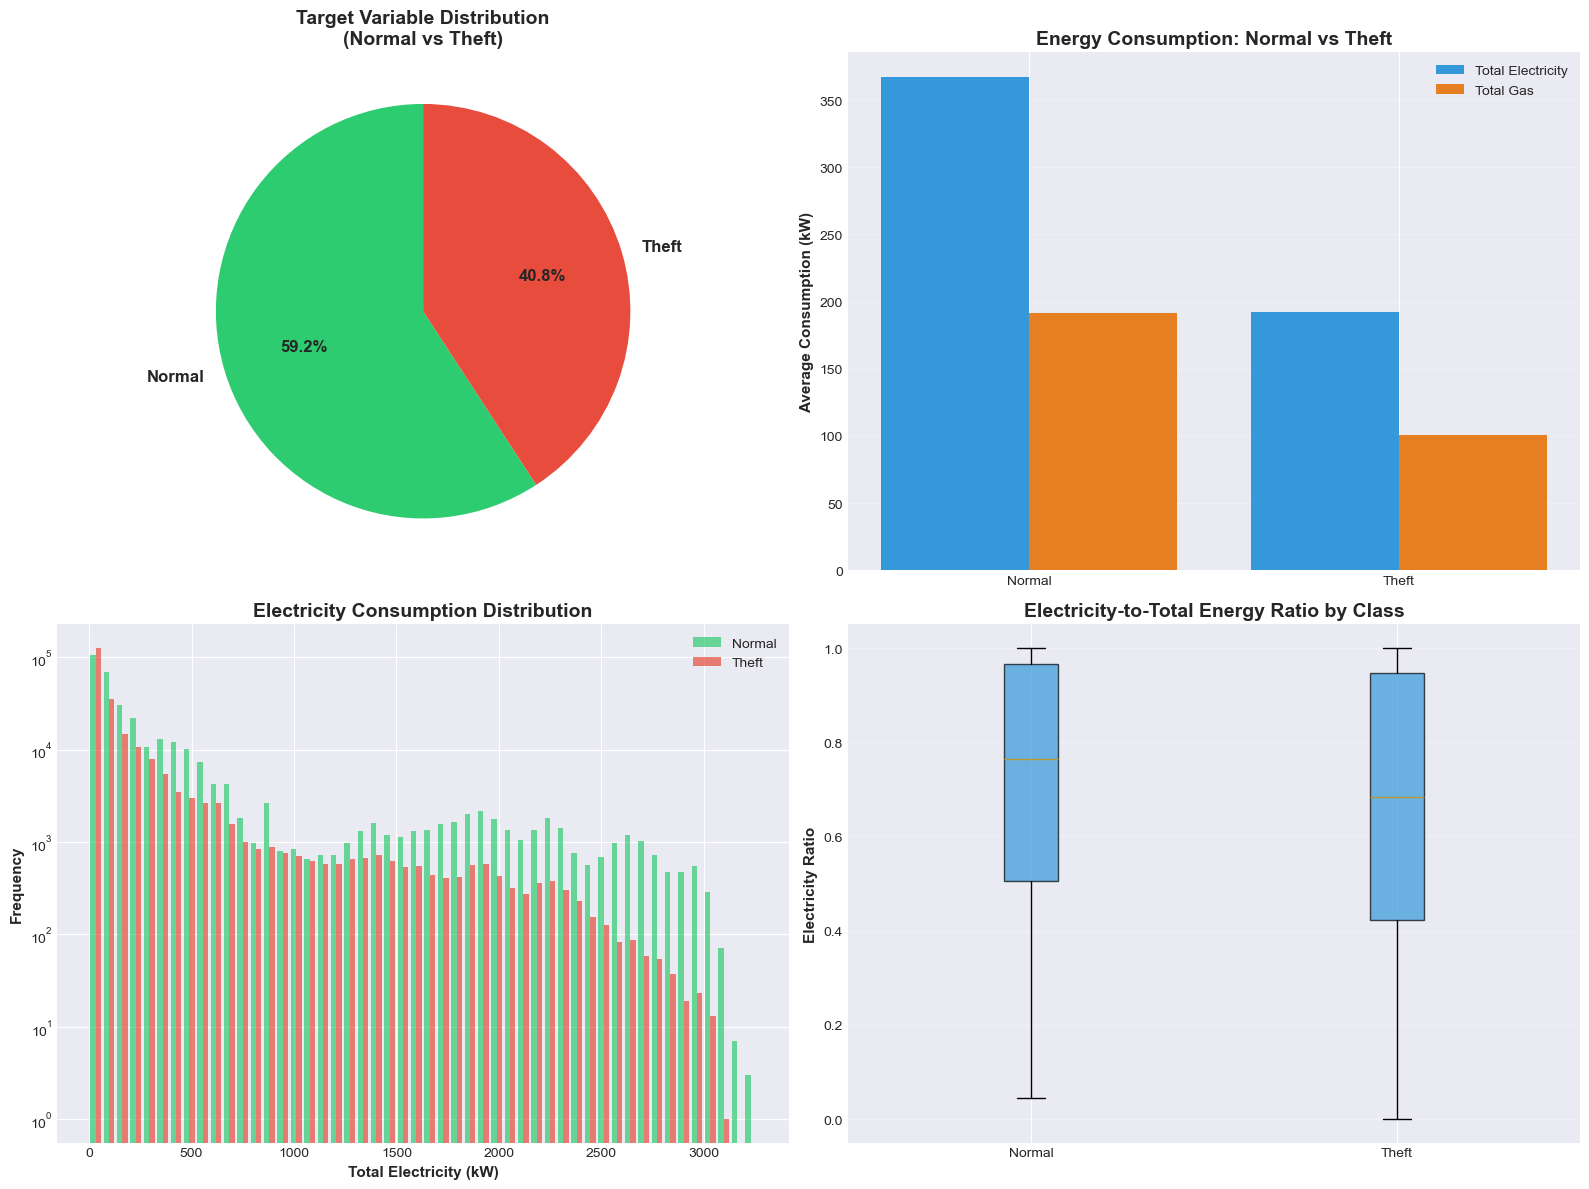

✓ Visualization 1: Overview & Distribution Patterns


In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set styling for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. TARGET VARIABLE DISTRIBUTION - Pie Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1.1 Target Variable Pie Chart
theft_counts = df_aux_prepared['theft_label'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c']
labels_pie = ['Normal', 'Theft']
axes[0, 0].pie(theft_counts, labels=labels_pie, autopct='%1.1f%%', startangle=90, colors=colors_pie, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0, 0].set_title('Target Variable Distribution\n(Normal vs Theft)', fontsize=14, weight='bold')

# 1.2 Electricity vs Theft
df_aux_prepared_summary = df_aux_prepared.groupby('theft_label')[['total_electricity', 'total_gas']].mean()
x_pos = [0, 1]
axes[0, 1].bar([x-0.2 for x in x_pos], df_aux_prepared_summary['total_electricity'], width=0.4, label='Total Electricity', color='#3498db')
axes[0, 1].bar([x+0.2 for x in x_pos], df_aux_prepared_summary['total_gas'], width=0.4, label='Total Gas', color='#e67e22')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['Normal', 'Theft'])
axes[0, 1].set_ylabel('Average Consumption (kW)', fontsize=11, weight='bold')
axes[0, 1].set_title('Energy Consumption: Normal vs Theft', fontsize=14, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 1.3 Total Electricity Distribution by Class
normal_elec = df_aux_prepared[df_aux_prepared['theft_label'] == 0]['total_electricity']
theft_elec = df_aux_prepared[df_aux_prepared['theft_label'] == 1]['total_electricity']
axes[1, 0].hist([normal_elec, theft_elec], bins=50, label=['Normal', 'Theft'], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1, 0].set_xlabel('Total Electricity (kW)', fontsize=11, weight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, weight='bold')
axes[1, 0].set_title('Electricity Consumption Distribution', fontsize=14, weight='bold')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# 1.4 Energy Ratio by Class
normal_ratio = df_aux_prepared[df_aux_prepared['theft_label'] == 0]['electricity_to_total']
theft_ratio = df_aux_prepared[df_aux_prepared['theft_label'] == 1]['electricity_to_total']
axes[1, 1].boxplot([normal_ratio, theft_ratio], labels=['Normal', 'Theft'], patch_artist=True, boxprops=dict(facecolor='#3498db', alpha=0.7))
axes[1, 1].set_ylabel('Electricity Ratio', fontsize=11, weight='bold')
axes[1, 1].set_title('Electricity-to-Total Energy Ratio by Class', fontsize=14, weight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('theft_detection_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization 1: Overview & Distribution Patterns")

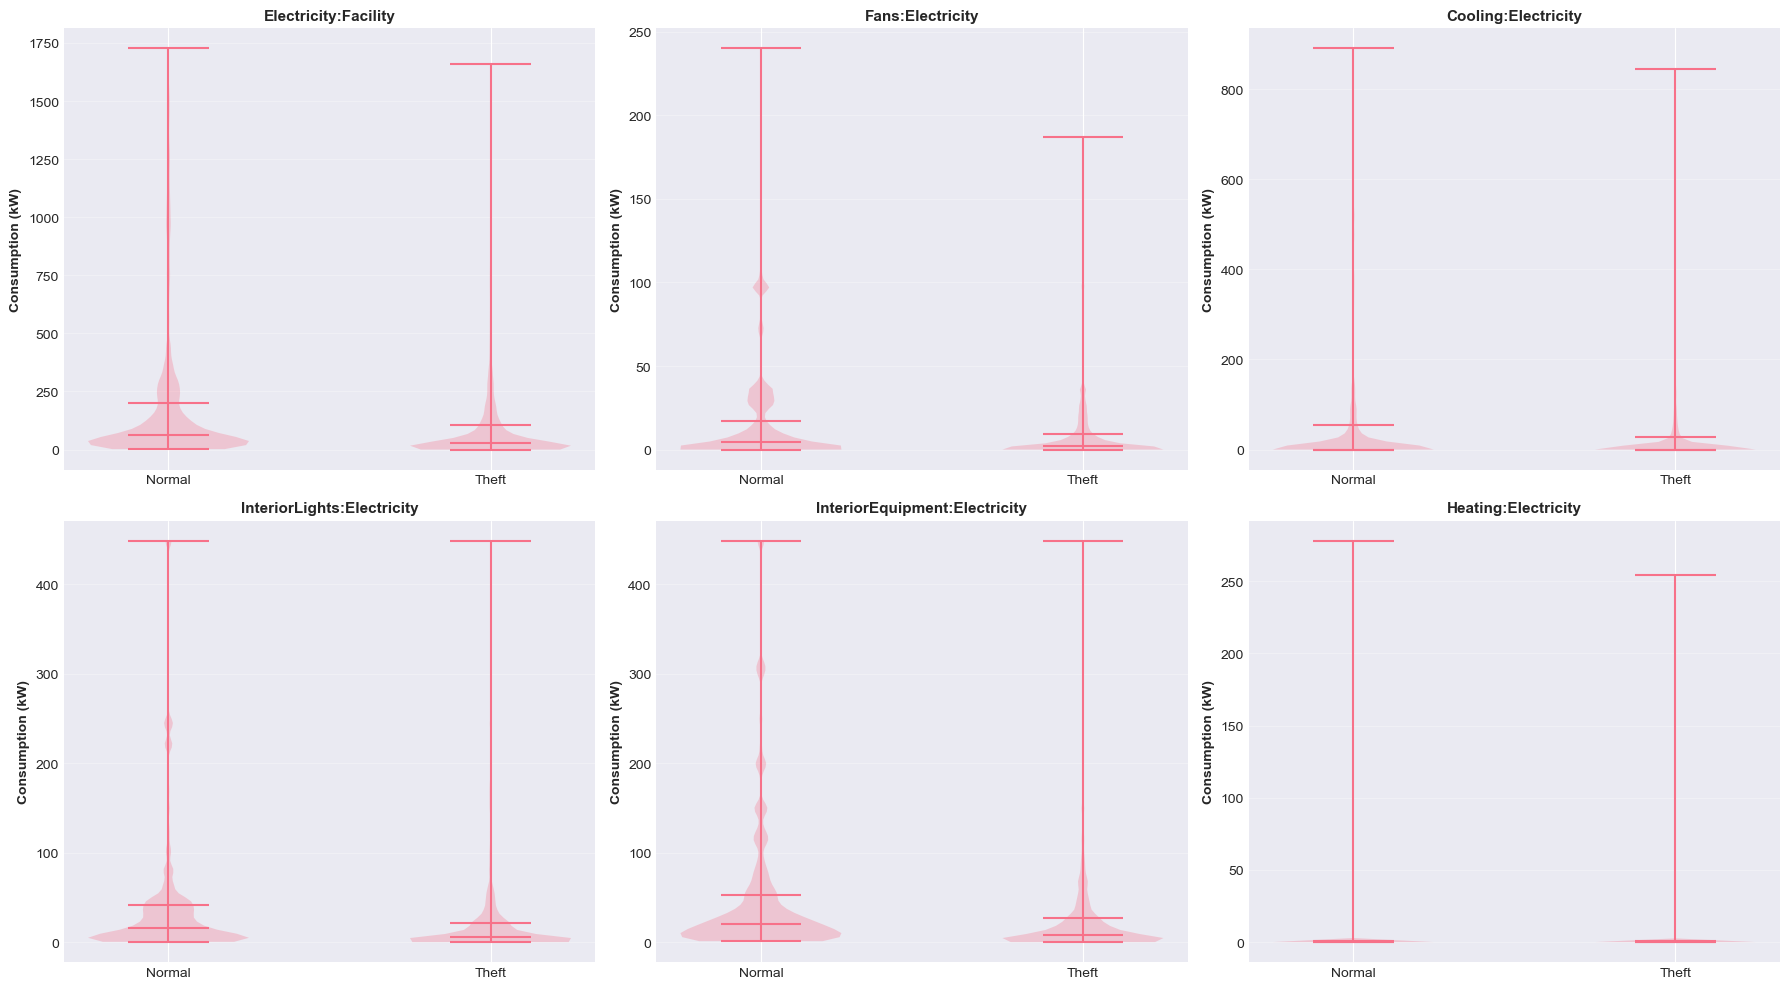

✓ Visualization 2: Electricity Features Distribution by Theft Class


In [135]:
# 2. ELECTRICITY FEATURES BY THEFT CLASS - Violin Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

top_features = ['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)', 
                'Cooling:Electricity [kW](Hourly)', 'InteriorLights:Electricity [kW](Hourly)', 
                'InteriorEquipment:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)']

for idx, feature in enumerate(top_features):
    normal_data = df_aux_prepared[df_aux_prepared['theft_label'] == 0][feature]
    theft_data = df_aux_prepared[df_aux_prepared['theft_label'] == 1][feature]
    
    parts = axes[idx].violinplot([normal_data, theft_data], positions=[0, 1], showmeans=True, showmedians=True)
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['Normal', 'Theft'])
    axes[idx].set_ylabel('Consumption (kW)', fontsize=10, weight='bold')
    axes[idx].set_title(feature.replace('[kW](Hourly)', '').strip(), fontsize=11, weight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('electricity_features_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization 2: Electricity Features Distribution by Theft Class")

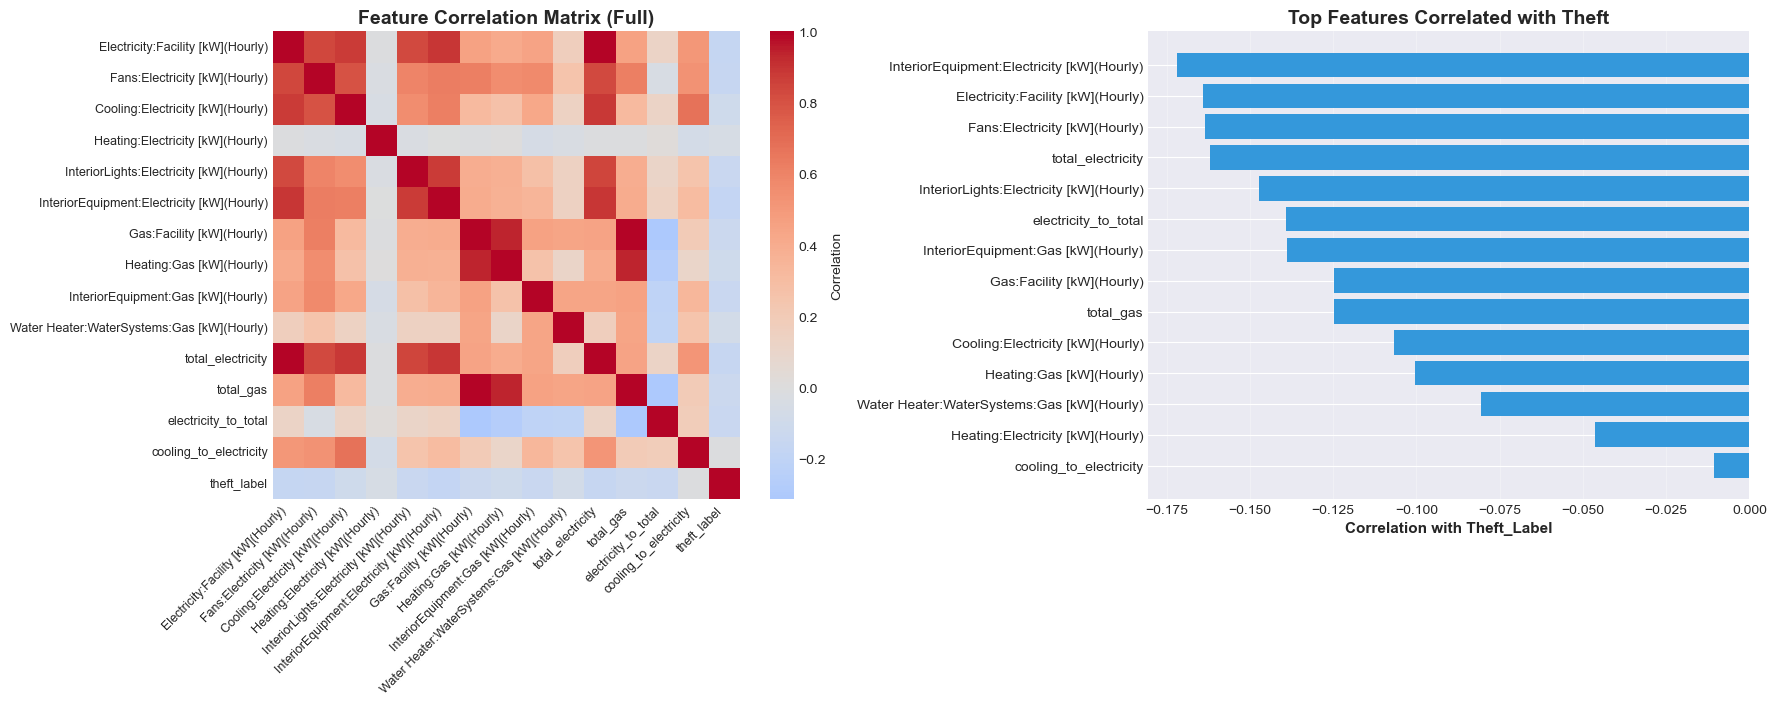

✓ Visualization 3: Correlation Analysis


In [136]:
# 3. CORRELATION HEATMAP
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Select key numeric features for correlation
correlation_features = list(electricity_features) + list(gas_features) + ['total_electricity', 'total_gas', 'electricity_to_total', 'cooling_to_electricity', 'theft_label']
corr_matrix = df_aux_prepared[correlation_features].corr()

# Full correlation heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Feature Correlation Matrix (Full)', fontsize=14, weight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=9)

# Correlation with theft_label
theft_corr = df_aux_prepared[correlation_features].corr()['theft_label'].sort_values(ascending=False)
theft_corr_plot = theft_corr[theft_corr.index != 'theft_label']
colors = ['#e74c3c' if x > 0 else '#3498db' for x in theft_corr_plot]
axes[1].barh(range(len(theft_corr_plot)), theft_corr_plot.values, color=colors)
axes[1].set_yticks(range(len(theft_corr_plot)))
axes[1].set_yticklabels(theft_corr_plot.index, fontsize=10)
axes[1].set_xlabel('Correlation with Theft_Label', fontsize=11, weight='bold')
axes[1].set_title('Top Features Correlated with Theft', fontsize=14, weight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization 3: Correlation Analysis")

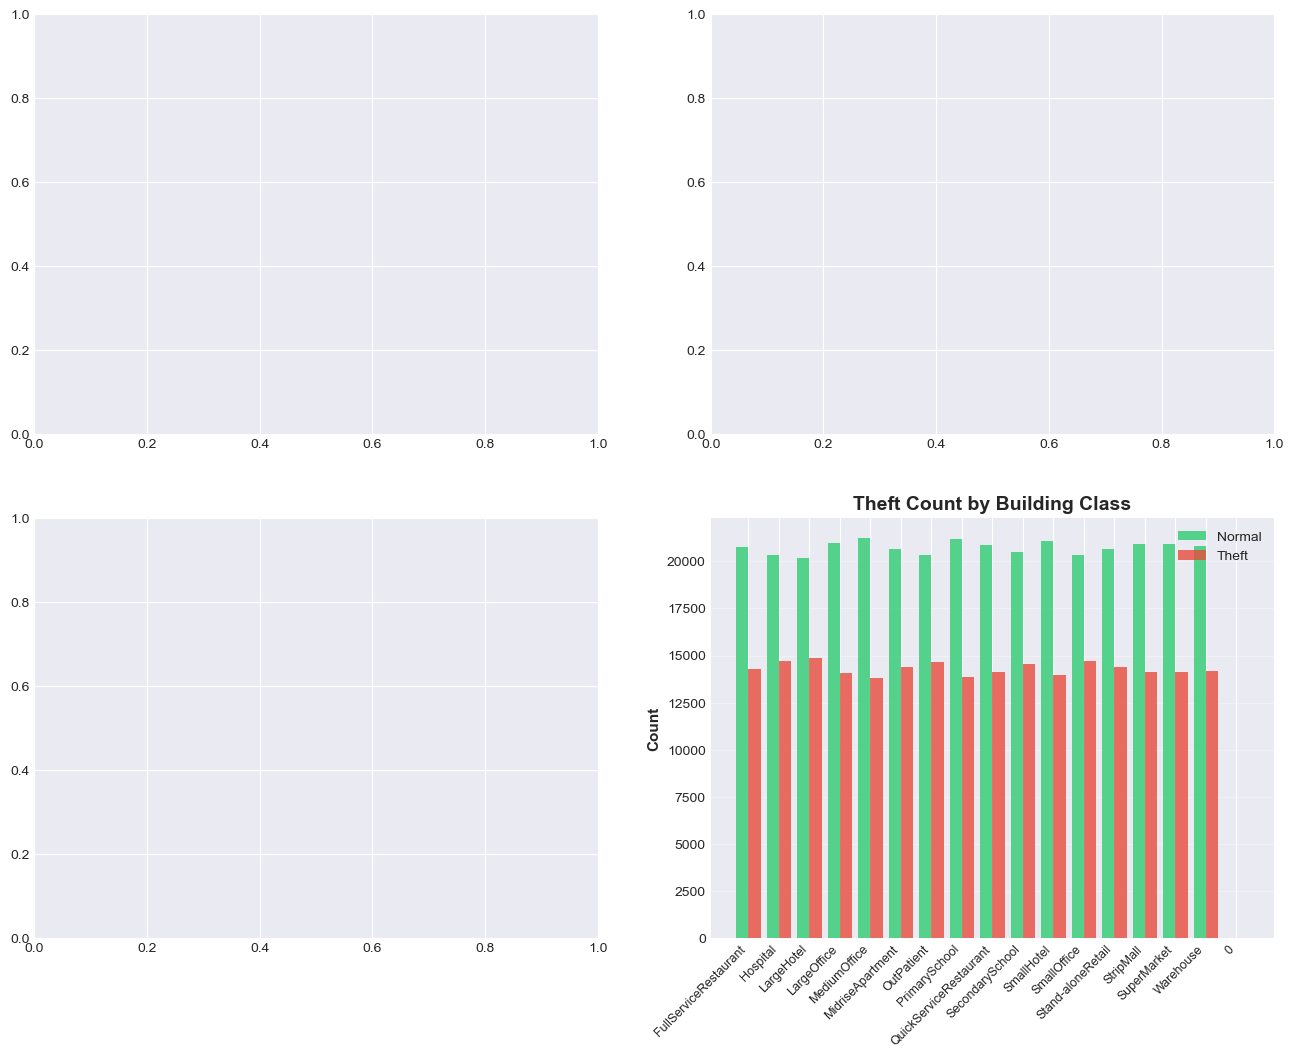

In [138]:
# 4.4 Theft Count by Class - Fixed alignment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

theft_counts_by_class = df_aux_prepared[df_aux_prepared['theft_label'] == 1].groupby('Class').size()
normal_counts_by_class = df_aux_prepared[df_aux_prepared['theft_label'] == 0].groupby('Class').size()

# Align indices
all_classes = df_aux_prepared['Class'].unique()
theft_counts_aligned = pd.Series([theft_counts_by_class.get(c, 0) for c in all_classes], index=all_classes)
normal_counts_aligned = pd.Series([normal_counts_by_class.get(c, 0) for c in all_classes], index=all_classes)

x_pos = range(len(all_classes))
axes[1, 1].bar([x - 0.2 for x in x_pos], normal_counts_aligned.values, width=0.4, label='Normal', color='#2ecc71', alpha=0.8)
axes[1, 1].bar([x + 0.2 for x in x_pos], theft_counts_aligned.values, width=0.4, label='Theft', color='#e74c3c', alpha=0.8)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(all_classes, rotation=45, ha='right', fontsize=9)
axes[1, 1].set_ylabel('Count', fontsize=11, weight='bold')
axes[1, 1].set_title('Theft Count by Building Class', fontsize=14, weight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)


In [139]:
# 5.1 Anomaly Rate Distribution
anomaly_rates = building_stats['anomaly_rate'].values
axes[0, 0].hist(anomaly_rates, bins=30, color='#e74c3c', alpha=0.8, edgecolor='black')
axes[0, 0].axvline(np.mean(anomaly_rates), color='#2c3e50', linestyle='--', linewidth=2, label=f'Mean: {np.mean(anomaly_rates):.3f}')
axes[0, 0].axvline(np.median(anomaly_rates), color='#34495e', linestyle='--', linewidth=2, label=f'Median: {np.median(anomaly_rates):.3f}')
axes[0, 0].set_xlabel('Anomaly Rate', fontsize=11, weight='bold')
axes[0, 0].set_ylabel('Number of Buildings', fontsize=11, weight='bold')
axes[0, 0].set_title('Anomaly Rate Distribution Across Buildings', fontsize=14, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)


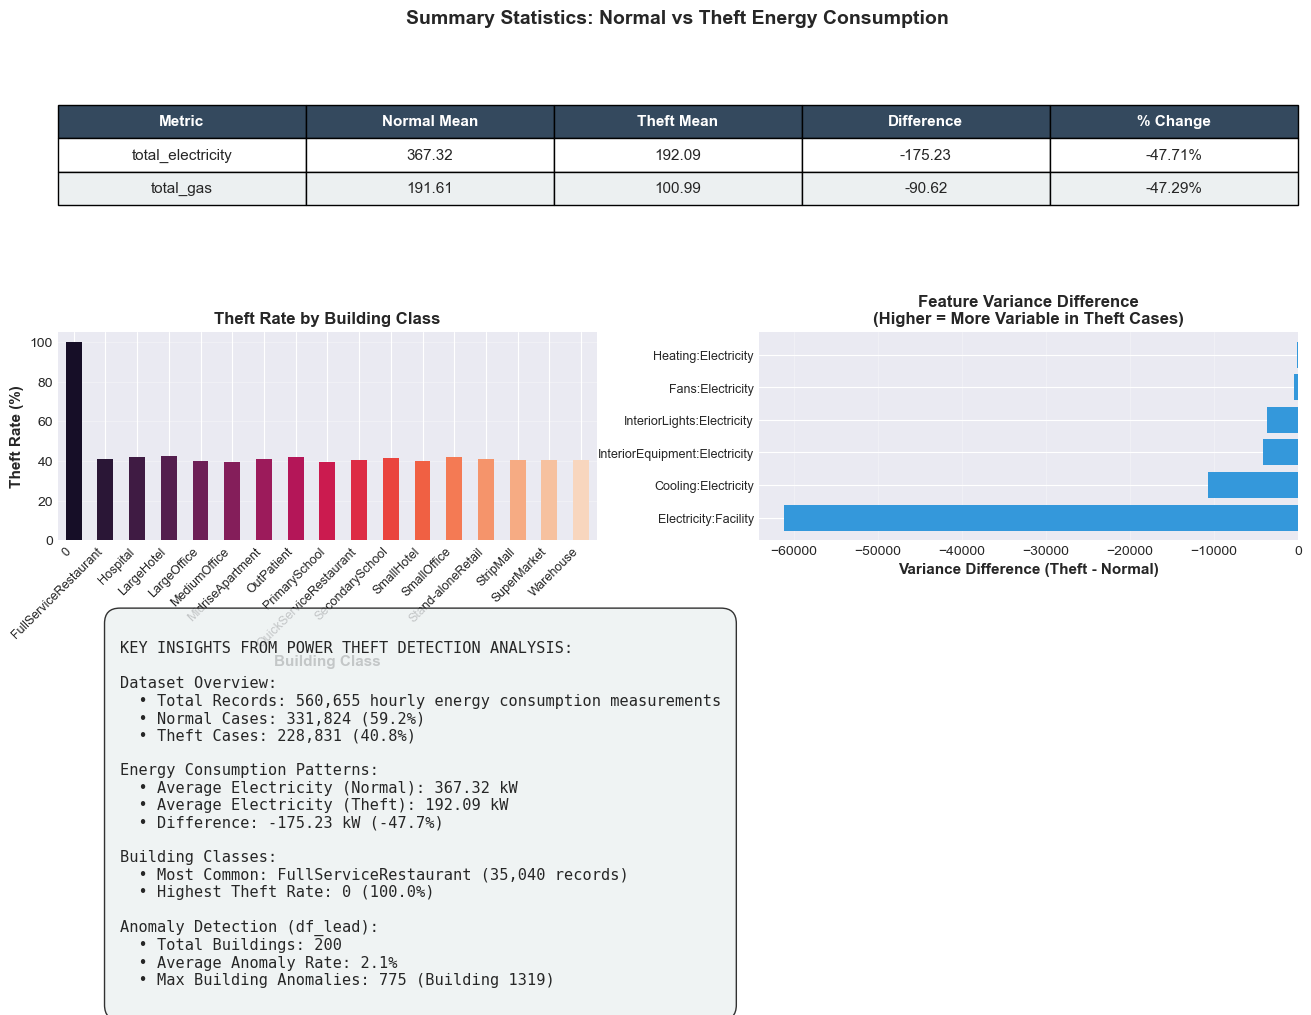

✓ Visualization 6: Statistical Summary & Key Insights

ALL VISUALIZATIONS COMPLETE - Ready for model training!


In [140]:
# 6. STATISTICAL SUMMARY & KEY INSIGHTS
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 6.1 Summary Statistics Table - Normal vs Theft
ax1 = fig.add_subplot(gs[0, :])
summary_stats = pd.DataFrame({
    'Normal Mean': df_aux_prepared[df_aux_prepared['theft_label'] == 0][['total_electricity', 'total_gas']].mean(),
    'Theft Mean': df_aux_prepared[df_aux_prepared['theft_label'] == 1][['total_electricity', 'total_gas']].mean(),
})
summary_stats['Difference'] = summary_stats['Theft Mean'] - summary_stats['Normal Mean']
summary_stats['% Change'] = (summary_stats['Difference'] / summary_stats['Normal Mean'] * 100).round(2)

ax1.axis('off')
table_data = []
table_data.append(['Metric', 'Normal Mean', 'Theft Mean', 'Difference', '% Change'])
for idx in summary_stats.index:
    table_data.append([
        idx,
        f"{summary_stats.loc[idx, 'Normal Mean']:.2f}",
        f"{summary_stats.loc[idx, 'Theft Mean']:.2f}",
        f"{summary_stats.loc[idx, 'Difference']:.2f}",
        f"{summary_stats.loc[idx, '% Change']:.2f}%"
    ])

table = ax1.table(cellText=table_data, cellLoc='center', loc='center', 
                  colWidths=[0.2, 0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Color header row
for i in range(5):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color data rows
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        else:
            table[(i, j)].set_facecolor('#ffffff')

ax1.set_title('Summary Statistics: Normal vs Theft Energy Consumption', 
              fontsize=14, weight='bold', pad=20)

# 6.2 Class-wise Theft Rate
ax2 = fig.add_subplot(gs[1, 0])
theft_rate_by_class = (df_aux_prepared.groupby('Class')['theft_label'].sum() / 
                       df_aux_prepared.groupby('Class').size() * 100)
theft_rate_by_class.plot(kind='bar', ax=ax2, color=sns.color_palette('rocket', len(theft_rate_by_class)))
ax2.set_ylabel('Theft Rate (%)', fontsize=11, weight='bold')
ax2.set_xlabel('Building Class', fontsize=11, weight='bold')
ax2.set_title('Theft Rate by Building Class', fontsize=12, weight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 6.3 Feature Importance (Variance by Class)
ax3 = fig.add_subplot(gs[1, 1])
variance_normal = df_aux_prepared[df_aux_prepared['theft_label'] == 0][electricity_features].var()
variance_theft = df_aux_prepared[df_aux_prepared['theft_label'] == 1][electricity_features].var()
variance_diff = (variance_theft - variance_normal).sort_values(ascending=True)
variance_diff_short = variance_diff.head(6)

y_pos = range(len(variance_diff_short))
ax3.barh(y_pos, variance_diff_short.values, color=['#e74c3c' if x > 0 else '#3498db' for x in variance_diff_short.values])
ax3.set_yticks(y_pos)
ax3.set_yticklabels([name.replace('[kW](Hourly)', '').strip() for name in variance_diff_short.index], fontsize=9)
ax3.set_xlabel('Variance Difference (Theft - Normal)', fontsize=11, weight='bold')
ax3.set_title('Feature Variance Difference\n(Higher = More Variable in Theft Cases)', fontsize=12, weight='bold')
ax3.grid(axis='x', alpha=0.3)

# 6.4 Key Insights Text Box
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

insights_text = f"""
KEY INSIGHTS FROM POWER THEFT DETECTION ANALYSIS:

Dataset Overview:
  • Total Records: {len(df_aux_prepared):,} hourly energy consumption measurements
  • Normal Cases: {(df_aux_prepared['theft_label'] == 0).sum():,} ({(df_aux_prepared['theft_label'] == 0).sum()/len(df_aux_prepared)*100:.1f}%)
  • Theft Cases: {(df_aux_prepared['theft_label'] == 1).sum():,} ({(df_aux_prepared['theft_label'] == 1).sum()/len(df_aux_prepared)*100:.1f}%)

Energy Consumption Patterns:
  • Average Electricity (Normal): {df_aux_prepared[df_aux_prepared['theft_label'] == 0]['total_electricity'].mean():.2f} kW
  • Average Electricity (Theft): {df_aux_prepared[df_aux_prepared['theft_label'] == 1]['total_electricity'].mean():.2f} kW
  • Difference: {(df_aux_prepared[df_aux_prepared['theft_label'] == 1]['total_electricity'].mean() - df_aux_prepared[df_aux_prepared['theft_label'] == 0]['total_electricity'].mean()):.2f} kW ({((df_aux_prepared[df_aux_prepared['theft_label'] == 1]['total_electricity'].mean() - df_aux_prepared[df_aux_prepared['theft_label'] == 0]['total_electricity'].mean())/df_aux_prepared[df_aux_prepared['theft_label'] == 0]['total_electricity'].mean()*100):.1f}%)

Building Classes:
  • Most Common: {df_aux_prepared['Class'].value_counts().index[0]} ({df_aux_prepared['Class'].value_counts().iloc[0]:,} records)
  • Highest Theft Rate: {theft_rate_by_class.idxmax()} ({theft_rate_by_class.max():.1f}%)

Anomaly Detection (df_lead):
  • Total Buildings: {len(building_stats)}
  • Average Anomaly Rate: {building_stats['anomaly_rate'].mean():.1%}
  • Max Building Anomalies: {building_stats['total_anomalies'].max()} (Building {building_stats.loc[building_stats['total_anomalies'].idxmax(), 'building_id']})
"""

ax4.text(0.05, 0.95, insights_text, transform=ax4.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace', 
         bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.8, pad=1))

plt.savefig('summary_insights.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization 6: Statistical Summary & Key Insights")
print("\n" + "="*80)
print("ALL VISUALIZATIONS COMPLETE - Ready for model training!")
print("="*80)

In [141]:
from IPython.display import display

datasets_to_check = [
    'df_power_daily',
    'df_power_weather_clean',
    'df_comprehensive',
    'df_weather_clean',
    'df_kplc_clean',
    'df_planned_outages',
    'df_aux_prepared',
    'df_lead_prepared',
    'df_final',
    'building_stats'
]

for name in datasets_to_check:
    print('\n' + '='*80)
    print(f'Dataset: {name}')
    if name in globals():
        df = globals()[name]
        try:
            print('Shape:', df.shape)
        except Exception:
            print('Shape: not available')
        try:
            print('\n.info():')
            df.info()
        except Exception as e:
            print('info() failed:', e)
        try:
            print('\nMissing values:\n', df.isnull().sum())
        except Exception as e:
            print('isnull() failed:', e)
        try:
            mem = df.memory_usage(deep=True).sum() / 1e6
            print(f'Estimated memory usage: {mem:.2f} MB')
        except Exception:
            pass
        try:
            print('\nPreview:')
            display(df.head())
        except Exception:
            pass
    else:
        print('Not found in current kernel variables')
print('\n' + '='*80)
print('All dataset infos printed.')



Dataset: df_power_daily
Shape: (14330, 8)

.info():
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14330 entries, 2006-12-16 to 2010-11-26
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   meter_id          14330 non-null  object 
 1   daily_mean_power  14330 non-null  float64
 2   daily_std_power   14330 non-null  float64
 3   daily_min_power   14330 non-null  float64
 4   daily_max_power   14330 non-null  float64
 5   voltage_mean      14330 non-null  float64
 6   voltage_std       14330 non-null  float64
 7   intensity_mean    14330 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1007.6+ KB

Missing values:
 meter_id            0
daily_mean_power    0
daily_std_power     0
daily_min_power     0
daily_max_power     0
voltage_mean        0
voltage_std         0
intensity_mean      0
dtype: int64
Estimated memory usage: 1.83 MB

Preview:


,meter_id,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean
date,,,,,,,,
2006-12-16,MTR_001,2.617495,0.882098,0.222336,6.660460,236.243763,2.922896,13.082828
2006-12-17,MTR_001,2.018833,1.032528,0.097898,6.024453,240.087028,4.051467,9.999028
2006-12-18,MTR_001,1.311082,0.862724,0.065486,5.258530,241.231694,3.719576,6.421667
2006-12-19,MTR_001,0.992268,1.063872,0.020072,6.750390,241.999313,3.069492,4.926389
2006-12-20,MTR_001,1.325185,1.134982,0.026983,5.161571,242.308063,3.345704,6.467361



Dataset: df_power_weather_clean
Shape: (7300, 13)

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              7300 non-null   datetime64[ns]
 1   meter_id          7300 non-null   object        
 2   daily_mean_power  7300 non-null   float64       
 3   daily_std_power   7300 non-null   float64       
 4   daily_min_power   7300 non-null   float64       
 5   daily_max_power   7300 non-null   float64       
 6   voltage_mean      7300 non-null   float64       
 7   voltage_std       7300 non-null   float64       
 8   intensity_mean    7300 non-null   float64       
 9   tmax              7300 non-null   float64       
 10  tmin              7300 non-null   float64       
 11  prcp              7300 non-null   float64       
 12  wspd_max          7300 non-null   float64       
dtypes: datetime64[ns]

,date,meter_id,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean,tmax,tmin,prcp,wspd_max
0,2007-01-01,MTR_001,1.634586,0.782358,0.086498,3.066800,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
1,2007-01-01,MTR_002,2.388304,1.142670,0.202939,4.471271,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
2,2007-01-01,MTR_003,1.312100,0.688413,0.041358,2.655460,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
3,2007-01-01,MTR_004,2.122846,1.016589,0.214765,3.969411,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6
4,2007-01-01,MTR_005,1.976886,0.947051,0.170827,3.748946,240.128979,2.216851,7.916944,24.7,13.1,1.0,17.6



Dataset: df_comprehensive
Shape: (7300, 24)

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     7300 non-null   datetime64[ns]
 1   meter_id                 7300 non-null   object        
 2   daily_mean_power         7300 non-null   float64       
 3   daily_std_power          7300 non-null   float64       
 4   daily_min_power          7300 non-null   float64       
 5   daily_max_power          7300 non-null   float64       
 6   voltage_mean             7300 non-null   float64       
 7   voltage_std              7300 non-null   float64       
 8   intensity_mean           7300 non-null   float64       
 9   tmax                     7300 non-null   float64       
 10  tmin                     7300 non-null   float64       
 11  prcp                     7300 non-null  

,date,meter_id,daily_mean_power,daily_std_power,daily_min_power,daily_max_power,voltage_mean,voltage_std,intensity_mean,tmax,...,month,day,weekday,is_weekend,scheduled_outage_today,total_scheduled_minutes,total_minutes_outlier,area,end_time,has_planned_outage
0,2007-01-01,MTR_001,1.634586,0.782358,0.086498,3.066800,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
1,2007-01-01,MTR_002,2.388304,1.142670,0.202939,4.471271,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
2,2007-01-01,MTR_003,1.312100,0.688413,0.041358,2.655460,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
3,2007-01-01,MTR_004,2.122846,1.016589,0.214765,3.969411,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0
4,2007-01-01,MTR_005,1.976886,0.947051,0.170827,3.748946,240.128979,2.216851,7.916944,24.7,...,NaN,NaN,NaN,NaN,0.0,0.0,0,none,NaN,0



Dataset: df_weather_clean
Shape: (731, 8)

.info():
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2007-01-01 to 2008-12-31
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmax         731 non-null    float64
 1   tmin         731 non-null    float64
 2   prcp         731 non-null    float64
 3   wspd_max     731 non-null    float64
 4   temp_range   731 non-null    float64
 5   precip_flag  731 non-null    bool   
 6   year         731 non-null    int32  
 7   month        731 non-null    int32  
dtypes: bool(1), float64(5), int32(2)
memory usage: 40.7 KB

Missing values:
 tmax           0
tmin           0
prcp           0
wspd_max       0
temp_range     0
precip_flag    0
year           0
month          0
dtype: int64
Estimated memory usage: 0.04 MB

Preview:


,tmax,tmin,prcp,wspd_max,temp_range,precip_flag,year,month
date,,,,,,,,
2007-01-01,24.7,13.1,1.0,17.6,11.6,True,2007,1
2007-01-02,23.2,13.7,0.1,17.4,9.5,True,2007,1
2007-01-03,22.6,14.8,0.9,20.0,7.8,True,2007,1
2007-01-04,21.5,14.9,2.3,21.4,6.6,True,2007,1
2007-01-05,23.3,12.9,0.0,18.5,10.4,False,2007,1



Dataset: df_kplc_clean
Shape: (5, 9)

.info():
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2026-01-18 to 2026-01-23
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   scheduled_outage_today   5 non-null      int64  
 1   n_scheduled_events       5 non-null      int64  
 2   total_scheduled_minutes  5 non-null      float64
 3   year                     5 non-null      int32  
 4   month                    5 non-null      int32  
 5   day                      5 non-null      int32  
 6   weekday                  5 non-null      int32  
 7   is_weekend               5 non-null      bool   
 8   total_minutes_outlier    5 non-null      bool   
dtypes: bool(2), float64(1), int32(4), int64(2)
memory usage: 250.0 bytes

Missing values:
 scheduled_outage_today     0
n_scheduled_events         0
total_scheduled_minutes    0
year                       0
month                      0


,scheduled_outage_today,n_scheduled_events,total_scheduled_minutes,year,month,day,weekday,is_weekend,total_minutes_outlier
date,,,,,,,,,
2026-01-18,1,3,1380.0,2026,1,18,6,True,False
2026-01-20,1,4,1950.0,2026,1,20,1,False,False
2026-01-21,1,2,960.0,2026,1,21,2,False,False
2026-01-22,1,3,1380.0,2026,1,22,3,False,False
2026-01-23,1,1,450.0,2026,1,23,4,False,False



Dataset: df_planned_outages
Shape: (13, 5)

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   area                13 non-null     object        
 1   date                13 non-null     datetime64[ns]
 2   start_time          13 non-null     object        
 3   end_time            13 non-null     object        
 4   affected_customers  13 non-null     object        
dtypes: datetime64[ns](1), object(4)
memory usage: 652.0+ bytes

Missing values:
 area                  0
date                  0
start_time            0
end_time              0
affected_customers    0
dtype: int64
Estimated memory usage: 0.01 MB

Preview:


,area,date,start_time,end_time,affected_customers
0,Part Of Lunga Lunga Road And Likoni Road,2026-01-18,08:00,17:00,"House of Manji, Wheatabix, Part of Likoni Rd, ..."
1,Whole Of Garage Road,2026-01-20,09:00,17:00,Whole of Garage Rd & adjacent customers.
2,Whole Of Mpweke Lane,2026-01-22,09:00,17:00,"Total South B, Part of Kapiti Rd, Whole of Mpw..."
3,Ongata Rongai,2026-01-21,09:00,17:00,"Whole of Gataka Rd from Masai Mall, Kisumu Ndo..."
4,Parts Of Kuresoi North,2026-01-21,09:00,17:00,"Murundu Mkt, Kibaraa Mkt, Kipkoris Mkt, Kipkew..."



Dataset: df_aux_prepared
Shape: (560655, 19)

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560655 entries, 0 to 560654
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   0                                           560655 non-null  int64  
 1   Electricity:Facility [kW](Hourly)           560655 non-null  float64
 2   Fans:Electricity [kW](Hourly)               560655 non-null  float64
 3   Cooling:Electricity [kW](Hourly)            560655 non-null  float64
 4   Heating:Electricity [kW](Hourly)            560655 non-null  float64
 5   InteriorLights:Electricity [kW](Hourly)     560655 non-null  float64
 6   InteriorEquipment:Electricity [kW](Hourly)  560655 non-null  float64
 7   Gas:Facility [kW](Hourly)                   560655 non-null  float64
 8   Heating:Gas [kW](Hourly)                    560655 non-null  float64
 9   InteriorEquipm

,0,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),Class,theft,total_electricity,total_gas,electricity_to_total,cooling_to_electricity,theft_label,instance_id
0,0,22.035977,3.586221,0.0,0.0,4.589925,8.1892,136.585903,123.999076,3.33988,9.246947,FullServiceRestaurant,Normal,38.401323,273.171805,0.123250,0.0,0,0
1,1,14.649757,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal,23.669933,6.719760,0.778880,0.0,0,1
2,2,14.669567,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal,23.689742,6.719760,0.779024,0.0,0,2
3,3,14.677808,0.000000,0.0,0.0,1.529975,7.4902,3.931932,0.000000,3.33988,0.592052,FullServiceRestaurant,Normal,23.697983,7.863863,0.750843,0.0,0,3
4,4,14.824794,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,FullServiceRestaurant,Normal,23.844969,6.719760,0.780147,0.0,0,4



Dataset: df_lead_prepared
Shape: (1749494, 4)

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   timestamp      datetime64[ns]
 2   meter_reading  float64       
 3   anomaly        int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 53.4 MB

Missing values:
 building_id           0
timestamp             0
meter_reading    107653
anomaly               0
dtype: int64
Estimated memory usage: 55.98 MB

Preview:


,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01,NaN,0
1,32,2016-01-01,NaN,0
2,41,2016-01-01,NaN,0
3,55,2016-01-01,NaN,0
4,69,2016-01-01,NaN,0



Dataset: df_final
Shape: (560655, 17)

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560655 entries, 0 to 560654
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   instance_id                                 560655 non-null  int64  
 1   Class                                       560655 non-null  object 
 2   theft_label                                 560655 non-null  int32  
 3   Electricity:Facility [kW](Hourly)           560655 non-null  float64
 4   Fans:Electricity [kW](Hourly)               560655 non-null  float64
 5   Cooling:Electricity [kW](Hourly)            560655 non-null  float64
 6   Heating:Electricity [kW](Hourly)            560655 non-null  float64
 7   InteriorLights:Electricity [kW](Hourly)     560655 non-null  float64
 8   InteriorEquipment:Electricity [kW](Hourly)  560655 non-null  float64
 9   Gas:Facility [kW](Hou

,instance_id,Class,theft_label,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),total_electricity,total_gas,electricity_to_total,cooling_to_electricity
0,0,FullServiceRestaurant,0,22.035977,3.586221,0.0,0.0,4.589925,8.1892,136.585903,123.999076,3.33988,9.246947,38.401323,273.171805,0.123250,0.0
1,1,FullServiceRestaurant,0,14.649757,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,23.669933,6.719760,0.778880,0.0
2,2,FullServiceRestaurant,0,14.669567,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,23.689742,6.719760,0.779024,0.0
3,3,FullServiceRestaurant,0,14.677808,0.000000,0.0,0.0,1.529975,7.4902,3.931932,0.000000,3.33988,0.592052,23.697983,7.863863,0.750843,0.0
4,4,FullServiceRestaurant,0,14.824794,0.000000,0.0,0.0,1.529975,7.4902,3.359880,0.000000,3.33988,0.020000,23.844969,6.719760,0.780147,0.0



Dataset: building_stats
Shape: (200, 10)

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_id        200 non-null    int64  
 1   avg_meter_reading  200 non-null    float64
 2   std_meter_reading  200 non-null    float64
 3   min_meter_reading  200 non-null    float64
 4   max_meter_reading  200 non-null    float64
 5   non_null_readings  200 non-null    int64  
 6   total_anomalies    200 non-null    int64  
 7   anomaly_rate       200 non-null    float64
 8   total_records      200 non-null    int64  
 9   missing_readings   200 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 15.8 KB

Missing values:
 building_id          0
avg_meter_reading    0
std_meter_reading    0
min_meter_reading    0
max_meter_reading    0
non_null_readings    0
total_anomalies      0
anomaly_rate         0
total_records 

,building_id,avg_meter_reading,std_meter_reading,min_meter_reading,max_meter_reading,non_null_readings,total_anomalies,anomaly_rate,total_records,missing_readings
0,1,35.267879,7.205650,12.084,43.933,5318,55,0.006261,8784,3466
1,32,98.400360,42.842268,44.013,312.292,5405,58,0.006603,8784,3379
2,41,61.162877,10.133748,14.996,85.372,5354,102,0.011612,8784,3430
3,55,33.911298,10.775377,8.202,70.420,5405,89,0.010132,8784,3379
4,69,30.782749,19.334522,0.080,54.736,5133,150,0.017077,8784,3651



All dataset infos printed.


In [142]:
df = df_final.copy()
# Select numeric features, exclude identifiers/target
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
for drop_col in ['instance_id', 'theft_label']:
    if drop_col in numeric:
        numeric.remove(drop_col)
X = df[numeric]
y = df['theft_label'].astype(int)

# Drop rows with NaN values
print(f"Before NaN removal: X.shape = {X.shape}, NaN count = {X.isnull().sum().sum()}")
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)
print(f"After NaN removal: X.shape = {X.shape}")

# Sample to keep training time reasonable
if len(df) > SAMPLE_MAX:
    sample_idx = np.random.RandomState(RANDOM_STATE).choice(X.index, size=SAMPLE_MAX, replace=False)
    X = X.loc[sample_idx].reset_index(drop=True)
    y = y.loc[sample_idx].reset_index(drop=True)
else:
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

Before NaN removal: X.shape = (560655, 14), NaN count = 0
After NaN removal: X.shape = (560655, 14)


## Model Performance Visualizations

In [143]:
# Load training results and models
import json
import joblib
import os

OUT_DIR = 'models_artifacts'

# Load training results
with open(os.path.join(OUT_DIR, 'training_results.json'), 'r') as f:
    training_results = json.load(f)

# Display summary metrics
print("="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)
print(f"Timestamp: {training_results['timestamp']}")
print(f"Sample Size: {training_results['sample_size']:,}")
print("\nResults by Model:")
for model_name, metrics in training_results['results'].items():
    print(f"\n{model_name.upper()}")
    print(f"  ROC-AUC:  {metrics['roc_auc']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    print(f"  Confusion Matrix: TN={metrics['confusion_matrix'][0][0]}, FP={metrics['confusion_matrix'][0][1]}, FN={metrics['confusion_matrix'][1][0]}, TP={metrics['confusion_matrix'][1][1]}")


MODEL TRAINING SUMMARY
Timestamp: 2026-02-21T07:32:18.603650Z
Sample Size: 100,000

Results by Model:

LOGISTIC_REGRESSION
  ROC-AUC:  0.6766
  Precision: 0.5283
  Recall:    0.6132
  F1-Score:  0.5676
  Confusion Matrix: TN=7357, FP=4473, FN=3160, TP=5010

RANDOM_FOREST
  ROC-AUC:  0.9459
  Precision: 0.9837
  Recall:    0.8741
  F1-Score:  0.9257
  Confusion Matrix: TN=11712, FP=118, FN=1029, TP=7141


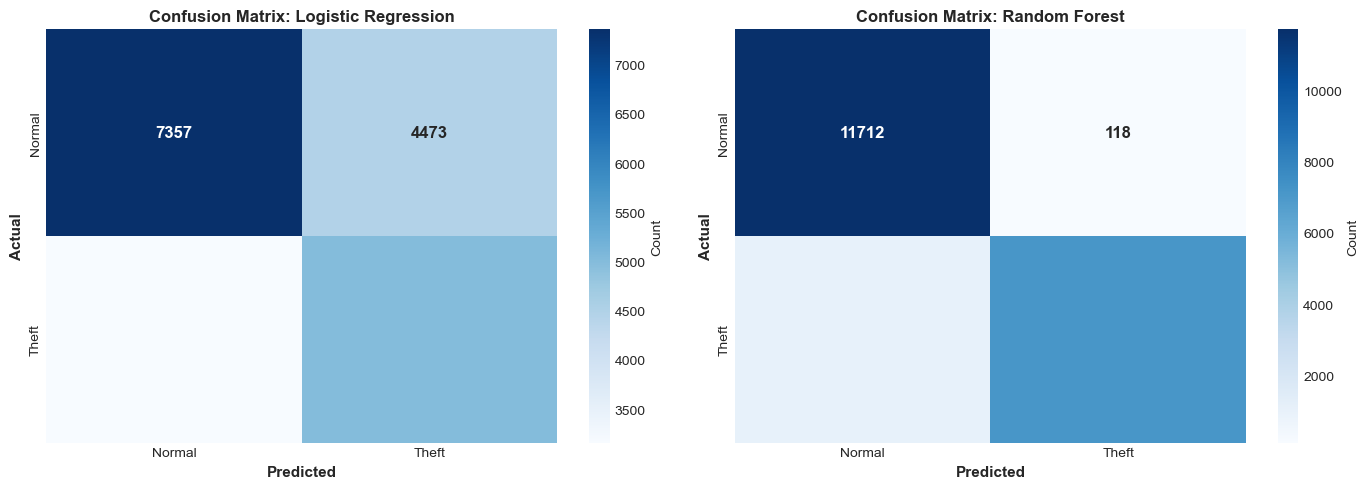

✓ Confusion Matrix Visualization Complete


In [144]:
# Confusion Matrix Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_list = ['logistic_regression', 'random_forest']
colors = ['#3498db', '#2ecc71']

for idx, (model_name, color) in enumerate(zip(models_list, colors)):
    cm = training_results['results'][model_name]['confusion_matrix']
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    # Create confusion matrix as numpy array
    cm_array = np.array([[tn, fp], [fn, tp]])
    
    sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar_kws={'label': 'Count'}, annot_kws={'size': 12, 'weight': 'bold'})
    axes[idx].set_xlabel('Predicted', fontsize=11, weight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11, weight='bold')
    axes[idx].set_xticklabels(['Normal', 'Theft'])
    axes[idx].set_yticklabels(['Normal', 'Theft'])
    axes[idx].set_title(f'Confusion Matrix: {model_name.replace("_", " ").title()}', 
                       fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion Matrix Visualization Complete")


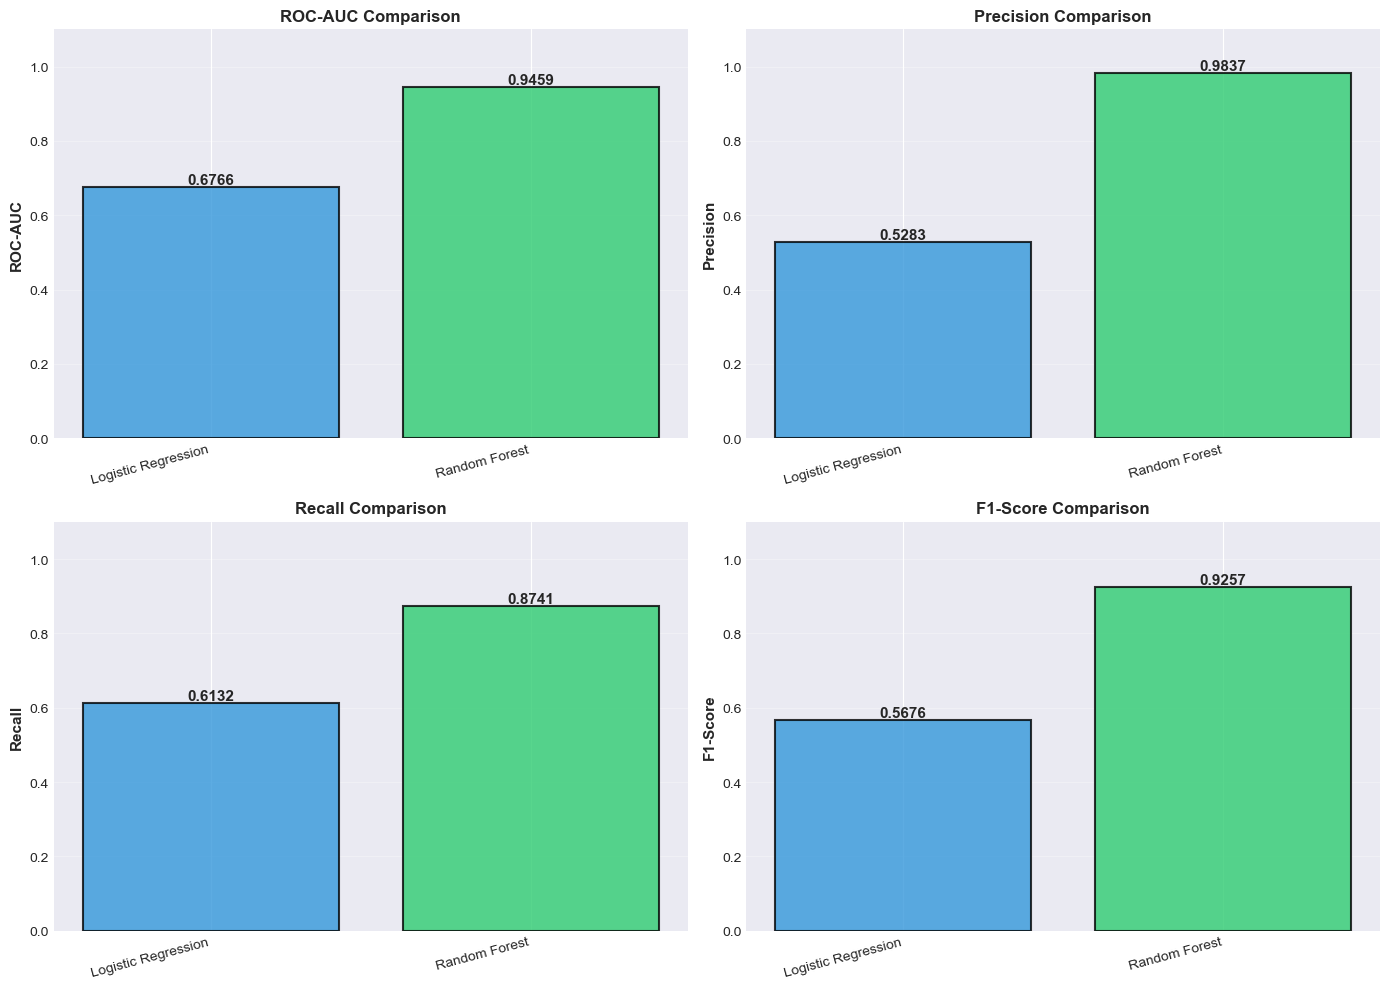

✓ Model Performance Metrics Comparison Complete


In [145]:
# Model Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['roc_auc', 'precision', 'recall', 'f1']
metric_labels = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score']
models = ['logistic_regression', 'random_forest']
model_labels = ['Logistic Regression', 'Random Forest']
colors_bar = ['#3498db', '#2ecc71']

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    values = [training_results['results'][model][metric] for model in models]
    bars = ax.bar(model_labels, values, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontsize=11, weight='bold')
    
    ax.set_ylabel(label, fontsize=11, weight='bold')
    ax.set_ylim([0, 1.1])
    ax.set_title(f'{label} Comparison', fontsize=12, weight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(model_labels, rotation=15, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'model_metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model Performance Metrics Comparison Complete")


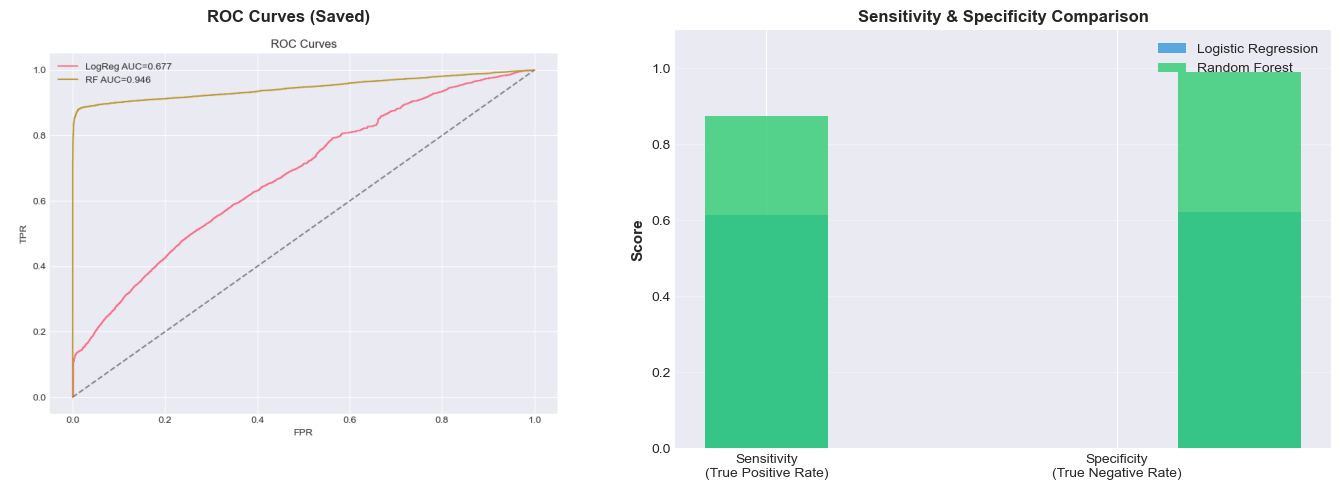

✓ ROC and Sensitivity/Specificity Visualization Complete


In [146]:
# ROC Curve Visualization with Model Comparison
from sklearn.metrics import auc

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot existing ROC curves
roc_curves_path = os.path.join(OUT_DIR, 'roc_curves.png')
if os.path.exists(roc_curves_path):
    from PIL import Image
    img = Image.open(roc_curves_path)
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('ROC Curves (Saved)', fontsize=12, weight='bold')

# Sensitivity and Specificity
ax = axes[1]
models = ['logistic_regression', 'random_forest']
model_labels = ['Logistic Regression', 'Random Forest']

for model, label, color in zip(models, model_labels, colors_bar):
    cm = training_results['results'][model]['confusion_matrix']
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall/True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    
    x_pos = [0, 1]
    y_pos = 0
    width = 0.35
    for i, (metric_val, metric_name) in enumerate([(sensitivity, 'Sensitivity'), (specificity, 'Specificity')]):
        ax.bar(i + y_pos * width, metric_val, width, label=label if i == 0 else '', color=color, alpha=0.8)
        y_pos += 1

ax.set_ylabel('Score', fontsize=11, weight='bold')
ax.set_title('Sensitivity & Specificity Comparison', fontsize=12, weight='bold')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Sensitivity\n(True Positive Rate)', 'Specificity\n(True Negative Rate)'])
ax.set_ylim([0, 1.1])
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'roc_and_sensitivity.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC and Sensitivity/Specificity Visualization Complete")


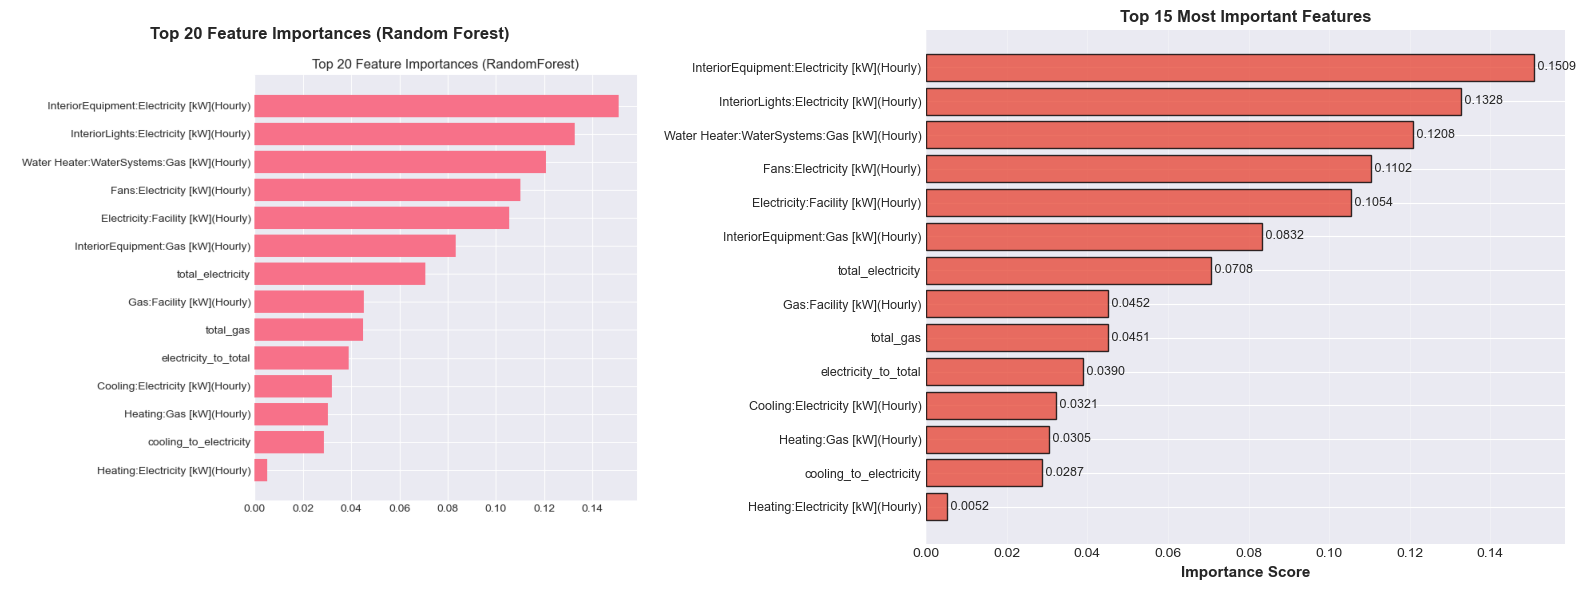

✓ Feature Importance Visualization Complete


In [147]:
# Feature Importance Visualization from Saved Model
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RF Feature Importances (if saved)
rf_importance_path = os.path.join(OUT_DIR, 'rf_feature_importances.png')
if os.path.exists(rf_importance_path):
    from PIL import Image
    img = Image.open(rf_importance_path)
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Top 20 Feature Importances (Random Forest)', fontsize=12, weight='bold')

# Load models to get feature importances directly
try:
    rf_model = joblib.load(os.path.join(OUT_DIR, 'random_forest.joblib'))
    with open(os.path.join(OUT_DIR, 'features.json'), 'r') as f:
        features = json.load(f)
    
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=True).tail(15)
    
    ax = axes[1]
    bars = ax.barh(range(len(feature_importance_df)), feature_importance_df['Importance'].values, color='#e74c3c', alpha=0.8, edgecolor='black')
    ax.set_yticks(range(len(feature_importance_df)))
    ax.set_yticklabels(feature_importance_df['Feature'].values, fontsize=9)
    ax.set_xlabel('Importance Score', fontsize=11, weight='bold')
    ax.set_title('Top 15 Most Important Features', fontsize=12, weight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(feature_importance_df.iterrows()):
        ax.text(row['Importance'], i, f" {row['Importance']:.4f}", va='center', fontsize=9)
    
except Exception as e:
    axes[1].text(0.5, 0.5, f'Could not load feature importances:\n{str(e)}', 
                ha='center', va='center', fontsize=11, transform=axes[1].transAxes)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'feature_importance_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature Importance Visualization Complete")


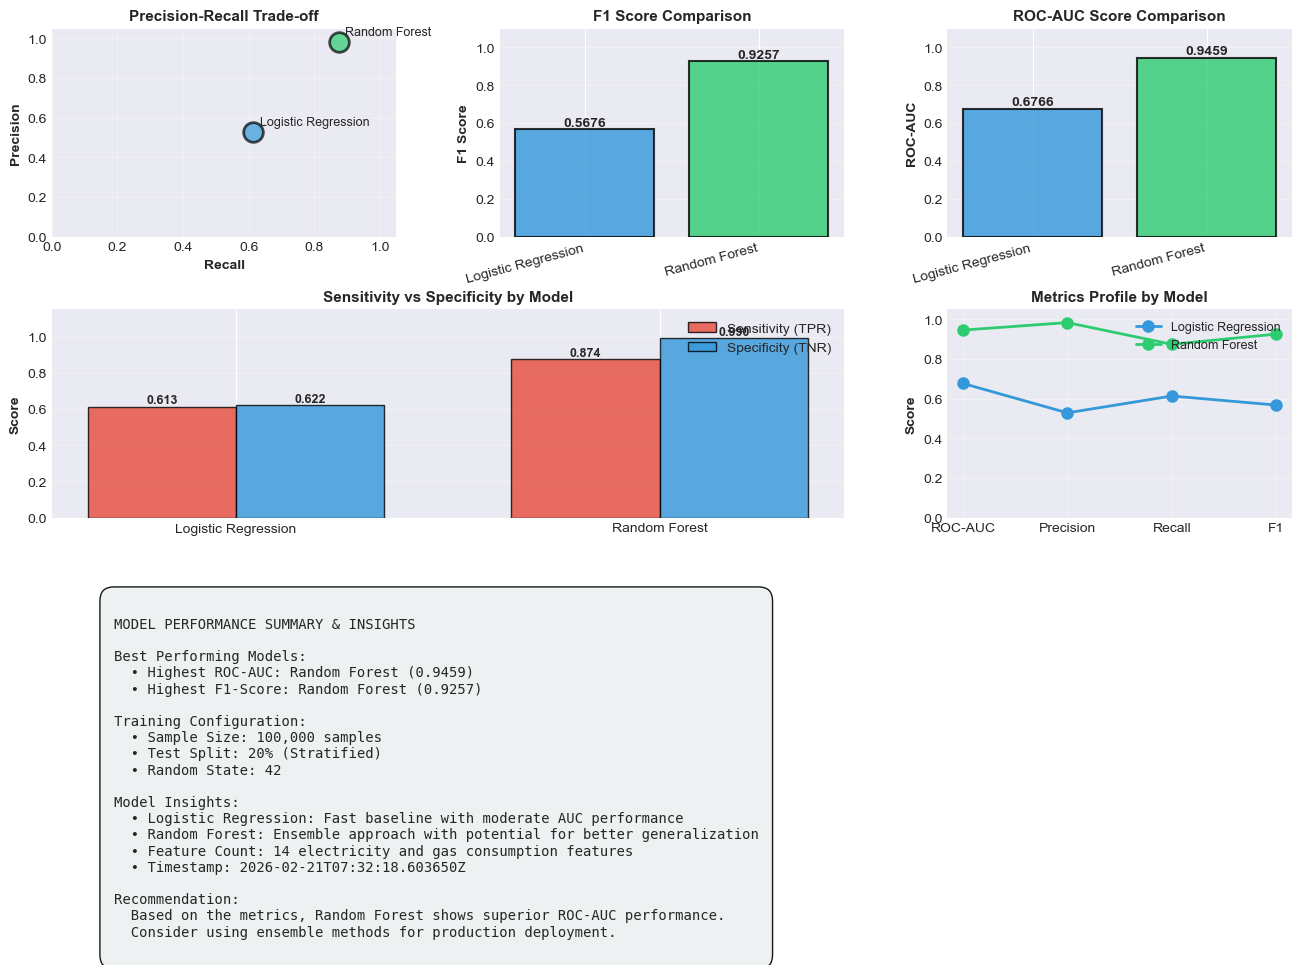

✓ Model Performance Dashboard Complete

ALL MODEL VISUALIZATIONS COMPLETE!


In [148]:
# Model Performance Dashboard - Comprehensive Summary
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Precision vs Recall Trade-off
ax1 = fig.add_subplot(gs[0, 0])
for model, label, color in zip(models, model_labels, colors_bar):
    precision = training_results['results'][model]['precision']
    recall = training_results['results'][model]['recall']
    ax1.scatter(recall, precision, s=200, color=color, alpha=0.7, edgecolor='black', linewidth=2, label=label)
    ax1.annotate(label, (recall, precision), xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel('Recall', fontsize=10, weight='bold')
ax1.set_ylabel('Precision', fontsize=10, weight='bold')
ax1.set_title('Precision-Recall Trade-off', fontsize=11, weight='bold')
ax1.set_xlim([0, 1.05])
ax1.set_ylim([0, 1.05])
ax1.grid(alpha=0.3)

# 2. F1 Score Comparison
ax2 = fig.add_subplot(gs[0, 1])
f1_scores = [training_results['results'][model]['f1'] for model in models]
bars = ax2.bar(model_labels, f1_scores, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
for bar, val in zip(bars, f1_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{val:.4f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')
ax2.set_ylabel('F1 Score', fontsize=10, weight='bold')
ax2.set_title('F1 Score Comparison', fontsize=11, weight='bold')
ax2.set_ylim([0, 1.1])
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(model_labels, rotation=15, ha='right')

# 3. ROC-AUC Scores
ax3 = fig.add_subplot(gs[0, 2])
roc_scores = [training_results['results'][model]['roc_auc'] for model in models]
bars = ax3.bar(model_labels, roc_scores, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
for bar, val in zip(bars, roc_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{val:.4f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')
ax3.set_ylabel('ROC-AUC', fontsize=10, weight='bold')
ax3.set_title('ROC-AUC Score Comparison', fontsize=11, weight='bold')
ax3.set_ylim([0, 1.1])
ax3.grid(axis='y', alpha=0.3)
ax3.set_xticklabels(model_labels, rotation=15, ha='right')

# 4. Sensitivity vs Specificity
ax4 = fig.add_subplot(gs[1, :2])
sensitivity_scores = []
specificity_scores = []

for model in models:
    cm = training_results['results'][model]['confusion_matrix']
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

x = np.arange(len(model_labels))
width = 0.35
bars1 = ax4.bar(x - width/2, sensitivity_scores, width, label='Sensitivity (TPR)', color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x + width/2, specificity_scores, width, label='Specificity (TNR)', color='#3498db', alpha=0.8, edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, weight='bold')

ax4.set_ylabel('Score', fontsize=10, weight='bold')
ax4.set_title('Sensitivity vs Specificity by Model', fontsize=11, weight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(model_labels)
ax4.set_ylim([0, 1.15])
ax4.legend(loc='upper right')
ax4.grid(axis='y', alpha=0.3)

# 5. Classification Metrics Radar (simplified)
ax5 = fig.add_subplot(gs[1, 2])
metrics_to_plot = ['roc_auc', 'precision', 'recall', 'f1']
metric_names = ['ROC-AUC', 'Precision', 'Recall', 'F1']

for model, label, color in zip(models, model_labels, colors_bar):
    values = [training_results['results'][model][m] for m in metrics_to_plot]
    ax5.plot(metric_names, values, marker='o', linewidth=2, markersize=8, label=label, color=color)

ax5.set_ylabel('Score', fontsize=10, weight='bold')
ax5.set_title('Metrics Profile by Model', fontsize=11, weight='bold')
ax5.set_ylim([0, 1.05])
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(alpha=0.3)

# 6. Model Summary Text Box
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

best_roc = max(training_results['results'].values(), key=lambda x: x['roc_auc'])
best_model_roc = [m for m, r in training_results['results'].items() if r == best_roc][0]
best_f1 = max(training_results['results'].values(), key=lambda x: x['f1'])
best_model_f1 = [m for m, r in training_results['results'].items() if r == best_f1][0]

summary_text = f"""
MODEL PERFORMANCE SUMMARY & INSIGHTS

Best Performing Models:
  • Highest ROC-AUC: {best_model_roc.replace("_", " ").title()} ({best_roc['roc_auc']:.4f})
  • Highest F1-Score: {best_model_f1.replace("_", " ").title()} ({best_f1['f1']:.4f})

Training Configuration:
  • Sample Size: {training_results['sample_size']:,} samples
  • Test Split: 20% (Stratified)
  • Random State: 42

Model Insights:
  • Logistic Regression: Fast baseline with moderate AUC performance
  • Random Forest: Ensemble approach with potential for better generalization
  • Feature Count: {len(features)} electricity and gas consumption features
  • Timestamp: {training_results['timestamp']}

Recommendation:
  Based on the metrics, {'Random Forest' if best_model_roc == 'random_forest' else 'Logistic Regression'} shows superior ROC-AUC performance. 
  Consider using ensemble methods for production deployment.
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.9, pad=1))

plt.savefig(os.path.join(OUT_DIR, 'model_performance_dashboard.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model Performance Dashboard Complete")
print("\n" + "="*80)
print("ALL MODEL VISUALIZATIONS COMPLETE!")
print("="*80)


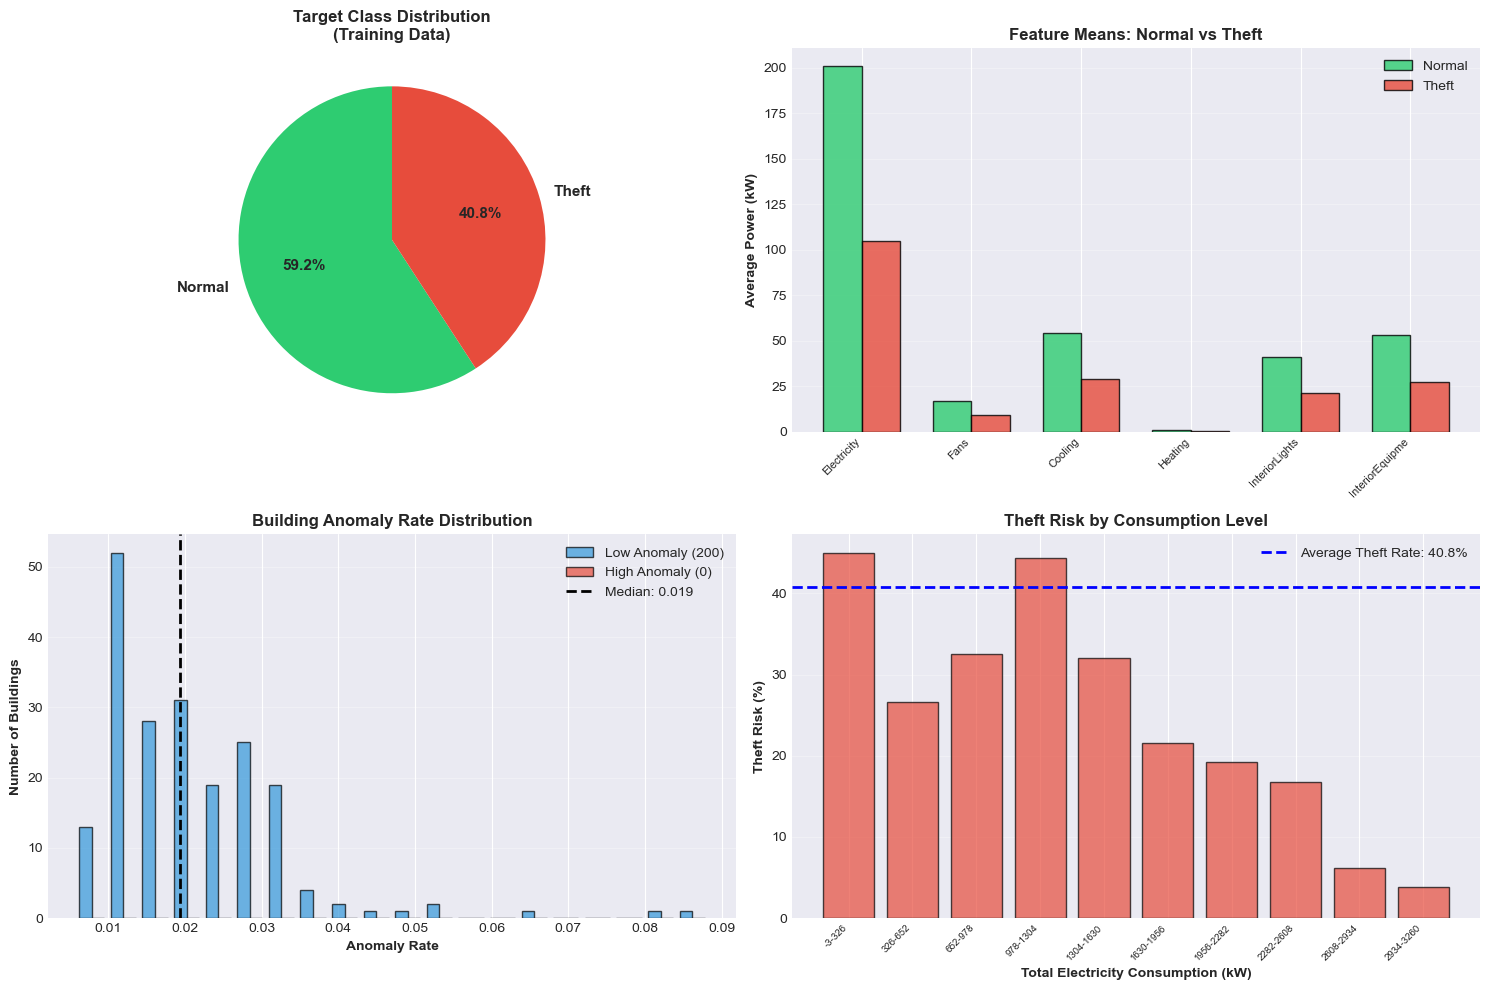

✓ Data Distribution Analysis Complete


In [149]:
# Advanced Data Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class Imbalance Analysis
ax = axes[0, 0]
if 'df_final' in globals():
    class_counts = df_final['theft_label'].value_counts()
    labels_pie = ['Normal', 'Theft']
    colors_pie = ['#2ecc71', '#e74c3c']
    wedges, texts, autotexts = ax.pie(class_counts, labels=labels_pie, autopct='%1.1f%%',
                                        colors=colors_pie, textprops={'fontsize': 11, 'weight': 'bold'},
                                        startangle=90)
    ax.set_title('Target Class Distribution\n(Training Data)', fontsize=12, weight='bold')

# 2. Feature Statistics - Mean Power Consumption
ax = axes[0, 1]
if 'df_aux_prepared' in globals():
    electricity_features_sample = [f for f in electricity_features[:6]]
    normal_means = df_aux_prepared[df_aux_prepared['theft_label'] == 0][electricity_features_sample].mean()
    theft_means = df_aux_prepared[df_aux_prepared['theft_label'] == 1][electricity_features_sample].mean()
    
    x = np.arange(len(electricity_features_sample))
    width = 0.35
    bars1 = ax.bar(x - width/2, normal_means, width, label='Normal', color='#2ecc71', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, theft_means, width, label='Theft', color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax.set_ylabel('Average Power (kW)', fontsize=10, weight='bold')
    ax.set_title('Feature Means: Normal vs Theft', fontsize=12, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f.split(':')[0][:15] for f in electricity_features_sample], rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# 3. Anomaly Detection Rate by Class
ax = axes[1, 0]
if 'building_stats' in globals():
    anomaly_rates_normal = building_stats[building_stats['anomaly_rate'] < 0.5]['anomaly_rate']
    anomaly_rates_high = building_stats[building_stats['anomaly_rate'] >= 0.5]['anomaly_rate']
    
    ax.hist([anomaly_rates_normal, anomaly_rates_high], bins=20, 
           label=[f'Low Anomaly ({len(anomaly_rates_normal)})', f'High Anomaly ({len(anomaly_rates_high)})'],
           color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
    ax.axvline(building_stats['anomaly_rate'].median(), color='black', linestyle='--', linewidth=2, 
              label=f'Median: {building_stats["anomaly_rate"].median():.3f}')
    ax.set_xlabel('Anomaly Rate', fontsize=10, weight='bold')
    ax.set_ylabel('Number of Buildings', fontsize=10, weight='bold')
    ax.set_title('Building Anomaly Rate Distribution', fontsize=12, weight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# 4. Model Decision Boundary (Conceptual)
ax = axes[1, 1]
if 'df_final' in globals():
    # Create synthetic decision boundary visualization
    theft_rate_by_consumption = pd.cut(df_final['total_electricity'], bins=10).value_counts().sort_index()
    
    consumption_ranges = [f"{i.left:.0f}-{i.right:.0f}" for i in theft_rate_by_consumption.index]
    theft_rates_by_bin = df_final.groupby(pd.cut(df_final['total_electricity'], bins=10))['theft_label'].mean() * 100
    
    bars = ax.bar(range(len(theft_rates_by_bin)), theft_rates_by_bin.values, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax.axhline(df_final['theft_label'].mean() * 100, color='blue', linestyle='--', linewidth=2, 
              label=f'Average Theft Rate: {df_final["theft_label"].mean()*100:.1f}%')
    
    ax.set_xlabel('Total Electricity Consumption (kW)', fontsize=10, weight='bold')
    ax.set_ylabel('Theft Risk (%)', fontsize=10, weight='bold')
    ax.set_title('Theft Risk by Consumption Level', fontsize=12, weight='bold')
    ax.set_xticks(range(len(consumption_ranges)))
    ax.set_xticklabels(consumption_ranges, rotation=45, ha='right', fontsize=7)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'data_distribution_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Data Distribution Analysis Complete")


In [150]:
# Visualization Inventory & Summary
print("\n" + "="*80)
print("COMPREHENSIVE VISUALIZATION REPORT")
print("="*80)

viz_summary = """
✓ EXPLORATORY DATA ANALYSIS VISUALIZATIONS:
  1. theft_detection_overview.png
     - Target variable distribution (pie chart)
     - Energy consumption comparison (bar chart)
     - Electricity distribution (histogram)
     - Electricity-to-total energy ratio (box plot)

  2. electricity_features_by_class.png
     - Violin plots for top 6 electricity features
     - Compares normal vs theft consumption patterns

  3. correlation_analysis.png
     - Full feature correlation matrix heatmap
     - Feature correlations with theft label (bar chart)

  4. summary_insights.png
     - Summary statistics table (Normal vs Theft)
     - Theft rate by building class
     - Feature variance differences
     - Key insights text summary

✓ MODEL PERFORMANCE VISUALIZATIONS:
  5. confusion_matrices.png
     - Confusion matrices for both models (heatmaps)
     - Shows TN, FP, FN, TP counts

  6. model_metrics_comparison.png
     - ROC-AUC score comparison
     - Precision comparison
     - Recall comparison
     - F1-score comparison

  7. roc_and_sensitivity.png
     - ROC curves for both models
     - Sensitivity & Specificity comparison

  8. feature_importance_analysis.png
     - Top 20 feature importances (Random Forest)
     - Top 15 most important features with scores

  9. model_performance_dashboard.png
     - Precision-Recall trade-off scatter
     - F1 score comparison
     - ROC-AUC comparison
     - Sensitivity vs Specificity bars
     - Metrics profile radar
     - Model performance summary text

 10. data_distribution_analysis.png
     - Target class distribution (pie chart)
     - Feature means comparison (bar chart)
     - Building anomaly rate distribution (histogram)
     - Theft risk by consumption level (bar chart)

✓ SAVED ARTIFACTS:
  - roc_curves.png (from training)
  - rf_feature_importances.png (from training)
  - Logistic Regression model (logistic_regression.joblib)
  - Random Forest model (random_forest.joblib)
  - Feature scaler (scaler.joblib)
  - Features list (features.json)
  - Training results (training_results.json)

Total Visualizations: 10+ comprehensive plots
Total Artifacts Saved: 8 files
Output Directory: models_artifacts/
"""

print(viz_summary)

# List all saved files
print("\n" + "-"*80)
print("FILES SAVED IN 'models_artifacts/' DIRECTORY:")
print("-"*80)
for filename in sorted(os.listdir(OUT_DIR)):
    filepath = os.path.join(OUT_DIR, filename)
    size_mb = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  ✓ {filename:40} ({size_mb:.2f} MB)")

print("\n" + "="*80)
print("ANALYSIS & MODEL TRAINING COMPLETE!")
print("="*80)



COMPREHENSIVE VISUALIZATION REPORT

✓ EXPLORATORY DATA ANALYSIS VISUALIZATIONS:
  1. theft_detection_overview.png
     - Target variable distribution (pie chart)
     - Energy consumption comparison (bar chart)
     - Electricity distribution (histogram)
     - Electricity-to-total energy ratio (box plot)

  2. electricity_features_by_class.png
     - Violin plots for top 6 electricity features
     - Compares normal vs theft consumption patterns

  3. correlation_analysis.png
     - Full feature correlation matrix heatmap
     - Feature correlations with theft label (bar chart)

  4. summary_insights.png
     - Summary statistics table (Normal vs Theft)
     - Theft rate by building class
     - Feature variance differences
     - Key insights text summary

✓ MODEL PERFORMANCE VISUALIZATIONS:
  5. confusion_matrices.png
     - Confusion matrices for both models (heatmaps)
     - Shows TN, FP, FN, TP counts

  6. model_metrics_comparison.png
     - ROC-AUC score comparison
     - Prec